GBIF.org (26 October 2024) GBIF Occurrence Download  https://doi.org/10.15468/dl.gu5t27

### Imports

In [51]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
import geopandas as gpd
from libpysal.weights import KNN
from esda.moran import Moran
from shapely.geometry import Point
import rasterio
from rasterio.plot import show
from scipy.stats import spearmanr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.stats import zscore
from shapely.geometry import Point, box

In [2]:
original_data = pd.read_csv('kenya_birds.csv', sep='\t')
original_data.head()

/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_44480/1727274082.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  original_data = pd.read_csv('kenya_birds.csv', sep='\t')


gbifID                            datasetKey  \
0  1986821111  d1e8a7af-097a-4ca8-aa91-62d3ff834711   
1  1986821110  d1e8a7af-097a-4ca8-aa91-62d3ff834711   
2  1986821109  d1e8a7af-097a-4ca8-aa91-62d3ff834711   
3  1986821108  d1e8a7af-097a-4ca8-aa91-62d3ff834711   
4  1986821107  d1e8a7af-097a-4ca8-aa91-62d3ff834711   

                           occurrenceID   kingdom    phylum class  \
0  d33e1483-ad6a-4aa2-95bd-5d4568a3cd3b  Animalia  Chordata  Aves   
1  d12a2b54-f12a-40a7-bfb5-90b4998af7d3  Animalia  Chordata  Aves   
2  ff92601a-f8b9-4db0-90a1-e4d0b233ace0  Animalia  Chordata  Aves   
3  a6bf4a1c-5c59-4a23-a18a-4ca9e6c36342  Animalia  Chordata  Aves   
4  215c7fe0-9e39-4497-86b5-87532c478ef8  Animalia  Chordata  Aves   

           order        family      genus                 species  ...  \
0  Passeriformes  Zosteropidae  Zosterops      Zosterops silvanus  ...   
1  Passeriformes  Zosteropidae  Zosterops  Zosterops senegalensis  ...   
2  Passeriformes  Zosteropidae  Zosterops  Zosterops senegalensis  ...   
3  Passeriformes  Zosteropidae  Zosterops      Zosterops silvanus  ...   
4  Passeriformes  Zosteropidae  Zosterops      Zosterops silvanus  ...   

  identifiedBy dateIdentified    license rightsHolder  recordedBy typeStatus  \
0          NaN            NaN  CC_BY_4_0          NaN         NaN        NaN   
1          NaN            NaN  CC_BY_4_0          NaN         NaN        NaN   
2          NaN            NaN  CC_BY_4_0          NaN         NaN        NaN   
3          NaN            NaN  CC_BY_4_0          NaN         NaN        NaN   
4          NaN            NaN  CC_BY_4_0          NaN         NaN        NaN   

   establishmentMeans           lastInterpreted mediaType  \
0                 NaN  2024-03-21T12:54:52.894Z       NaN   
1                 NaN  2024-03-21T12:54:54.972Z       NaN   
2                 NaN  2024-03-21T12:54:57.153Z       NaN   
3                 NaN  2024-03-21T12:55:11.136Z       NaN   
4                 NaN  2024-03-21T12:54:51.116Z       NaN   

                                               issue  
0  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...  
1  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...  
2  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...  
3  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...  
4  COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...  

[5 rows x 50 columns]

### Data pre-processing

First, let's remove rows that are irrelevant for our analysis:

In [3]:
df1 = original_data.drop(['gbifID', 'datasetKey', 'occurrenceID', 'verbatimScientificNameAuthorship', 'countryCode', 'publishingOrgKey', 'institutionCode', 'collectionCode', 
                 'catalogNumber', 'recordNumber', 'license', 'rightsHolder', 'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted', 'issue'], axis=1)

df1.head()

kingdom    phylum class          order        family      genus  \
0  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
1  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
2  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
3  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
4  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   

                  species infraspecificEpithet taxonRank  \
0      Zosterops silvanus                  NaN   SPECIES   
1  Zosterops senegalensis                  NaN   SPECIES   
2  Zosterops senegalensis                  NaN   SPECIES   
3      Zosterops silvanus                  NaN   SPECIES   
4      Zosterops silvanus                  NaN   SPECIES   

                                    scientificName  ...   eventDate  day  \
0  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...  2017-11-09    9   
1           Zosterops senegalensis Bonaparte, 1850  ...  2017-06-01    1   
2           Zosterops senegalensis Bonaparte, 1850  ...  2017-06-01    1   
3  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...  2017-10-06    6   
4  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...  2017-10-06    6   

   month  year  taxonKey  speciesKey      basisOfRecord  identifiedBy  \
0     11  2017   6100772   6100772.0  HUMAN_OBSERVATION           NaN   
1      6  2017   2489344   2489344.0  HUMAN_OBSERVATION           NaN   
2      6  2017   2489344   2489344.0  HUMAN_OBSERVATION           NaN   
3     10  2017   6100772   6100772.0  HUMAN_OBSERVATION           NaN   
4     10  2017   6100772   6100772.0  HUMAN_OBSERVATION           NaN   

   dateIdentified  mediaType  
0             NaN        NaN  
1             NaN        NaN  
2             NaN        NaN  
3             NaN        NaN  
4             NaN        NaN  

[5 rows x 33 columns]

Now, let's remove columns that are a form of duplicate of other columns:

In [4]:
df2 = df1.drop(['day', 'month', 'year', 'dateIdentified' # the date is contained in 'eventDate'
                ], axis=1)

df2.head()

kingdom    phylum class          order        family      genus  \
0  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
1  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
2  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
3  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
4  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   

                  species infraspecificEpithet taxonRank  \
0      Zosterops silvanus                  NaN   SPECIES   
1  Zosterops senegalensis                  NaN   SPECIES   
2  Zosterops senegalensis                  NaN   SPECIES   
3      Zosterops silvanus                  NaN   SPECIES   
4      Zosterops silvanus                  NaN   SPECIES   

                                    scientificName  ... elevation  \
0  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...       NaN   
1           Zosterops senegalensis Bonaparte, 1850  ...       NaN   
2           Zosterops senegalensis Bonaparte, 1850  ...       NaN   
3  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...       NaN   
4  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...       NaN   

   elevationAccuracy  depth depthAccuracy   eventDate  taxonKey  speciesKey  \
0                NaN    NaN           NaN  2017-11-09   6100772   6100772.0   
1                NaN    NaN           NaN  2017-06-01   2489344   2489344.0   
2                NaN    NaN           NaN  2017-06-01   2489344   2489344.0   
3                NaN    NaN           NaN  2017-10-06   6100772   6100772.0   
4                NaN    NaN           NaN  2017-10-06   6100772   6100772.0   

       basisOfRecord  identifiedBy  mediaType  
0  HUMAN_OBSERVATION           NaN        NaN  
1  HUMAN_OBSERVATION           NaN        NaN  
2  HUMAN_OBSERVATION           NaN        NaN  
3  HUMAN_OBSERVATION           NaN        NaN  
4  HUMAN_OBSERVATION           NaN        NaN  

[5 rows x 29 columns]

Next, we see that a couple of columns seem to take the same values for each row, let's check that:

In [5]:
unique_occurrence_status = df2['occurrenceStatus'].unique()
unique_basis_of_record = df2['basisOfRecord'].unique()

print("Unique values in 'occurrenceStatus':")
print(unique_occurrence_status)

print("\nUnique values in 'basisOfRecord':")
print(unique_basis_of_record)

Unique values in 'occurrenceStatus':
['PRESENT']

Unique values in 'basisOfRecord':
['HUMAN_OBSERVATION']


Let's remove those columns as well since they take the same value for all rows:

In [6]:
df = df2.drop(['occurrenceStatus', 'basisOfRecord'], axis=1)

df.head()

kingdom    phylum class          order        family      genus  \
0  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
1  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
2  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
3  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
4  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   

                  species infraspecificEpithet taxonRank  \
0      Zosterops silvanus                  NaN   SPECIES   
1  Zosterops senegalensis                  NaN   SPECIES   
2  Zosterops senegalensis                  NaN   SPECIES   
3      Zosterops silvanus                  NaN   SPECIES   
4      Zosterops silvanus                  NaN   SPECIES   

                                    scientificName  ... coordinatePrecision  \
0  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...                 NaN   
1           Zosterops senegalensis Bonaparte, 1850  ...                 NaN   
2           Zosterops senegalensis Bonaparte, 1850  ...                 NaN   
3  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...                 NaN   
4  Zosterops silvanus J.L.Peters & Loveridge, 1935  ...                 NaN   

   elevation  elevationAccuracy  depth  depthAccuracy   eventDate  taxonKey  \
0        NaN                NaN    NaN            NaN  2017-11-09   6100772   
1        NaN                NaN    NaN            NaN  2017-06-01   2489344   
2        NaN                NaN    NaN            NaN  2017-06-01   2489344   
3        NaN                NaN    NaN            NaN  2017-10-06   6100772   
4        NaN                NaN    NaN            NaN  2017-10-06   6100772   

   speciesKey  identifiedBy  mediaType  
0   6100772.0           NaN        NaN  
1   2489344.0           NaN        NaN  
2   2489344.0           NaN        NaN  
3   6100772.0           NaN        NaN  
4   6100772.0           NaN        NaN  

[5 rows x 27 columns]

Let's check for missing values:

In [7]:
missing_counts = df2.isnull().sum()

total_rows = len(df2)
missing_percentage = (missing_counts / total_rows) * 100

missing_summary = pd.DataFrame({
    'Column Name': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing Percentage': missing_percentage.values
})

print(missing_summary)

                      Column Name  Missing Count  Missing Percentage
0                         kingdom              0            0.000000
1                          phylum              0            0.000000
2                           class              0            0.000000
3                           order              0            0.000000
4                          family              0            0.000000
5                           genus              0            0.000000
6                         species            185            0.206400
7            infraspecificEpithet          89593           99.956489
8                       taxonRank              0            0.000000
9                  scientificName              0            0.000000
10         verbatimScientificName              0            0.000000
11                       locality          89632          100.000000
12                  stateProvince          89632          100.000000
13               occurrenceStatus 

First, let's remove the columns with nearly all, or all values missing:

In [8]:
df3 = df2.drop(['infraspecificEpithet', 'locality', 'stateProvince', 'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation', 'elevationAccuracy',
                'depth', 'depthAccuracy', 'identifiedBy', 'mediaType'], axis=1)

df3.head()

kingdom    phylum class          order        family      genus  \
0  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
1  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
2  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
3  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   
4  Animalia  Chordata  Aves  Passeriformes  Zosteropidae  Zosterops   

                  species taxonRank  \
0      Zosterops silvanus   SPECIES   
1  Zosterops senegalensis   SPECIES   
2  Zosterops senegalensis   SPECIES   
3      Zosterops silvanus   SPECIES   
4      Zosterops silvanus   SPECIES   

                                    scientificName  verbatimScientificName  \
0  Zosterops silvanus J.L.Peters & Loveridge, 1935      Zosterops silvanus   
1           Zosterops senegalensis Bonaparte, 1850  Zosterops senegalensis   
2           Zosterops senegalensis Bonaparte, 1850  Zosterops senegalensis   
3  Zosterops silvanus J.L.Peters & Loveridge, 1935      Zosterops silvanus   
4  Zosterops silvanus J.L.Peters & Loveridge, 1935      Zosterops silvanus   

  occurrenceStatus  individualCount  decimalLatitude  decimalLongitude  \
0          PRESENT              1.0        -3.432285         38.341012   
1          PRESENT              1.0         0.206000         34.884667   
2          PRESENT              4.0        -0.558500         36.523667   
3          PRESENT              1.0        -3.399601         38.329516   
4          PRESENT              1.0        -3.380438         38.353286   

    eventDate  taxonKey  speciesKey      basisOfRecord  
0  2017-11-09   6100772   6100772.0  HUMAN_OBSERVATION  
1  2017-06-01   2489344   2489344.0  HUMAN_OBSERVATION  
2  2017-06-01   2489344   2489344.0  HUMAN_OBSERVATION  
3  2017-10-06   6100772   6100772.0  HUMAN_OBSERVATION  
4  2017-10-06   6100772   6100772.0  HUMAN_OBSERVATION

In [9]:
df.shape

(89632, 27)

Finally, let's handle the remaining missing values.

- For column 'individualCount', we will replace the missing values by the median of the column. It is a more accurate replacement than the mean due to some extreme outliers, especially since both quartiles are equal to 1.
- For columns 'species' and 'speciesKey', we will delete the rows with missing values, as there is only a very tiny percentage of those and we will still have a very rich data set afterwards.

In [10]:
df['individualCount'].describe()

count    89552.000000
mean         2.081472
std         34.485674
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       7000.000000
Name: individualCount, dtype: float64

In [11]:
df['individualCount'].fillna(df['individualCount'].median(), inplace=True)
df.dropna(subset=['species', 'speciesKey'], inplace=True)

/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_44480/3135754652.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['individualCount'].fillna(df['individualCount'].median(), inplace=True)


In [12]:
upd_missing_counts = df.isnull().sum()

upd_total_rows = len(df)
upd_missing_percentage = (upd_missing_counts / upd_total_rows) * 100

upd_missing_summary = pd.DataFrame({
    'Column Name': upd_missing_counts.index,
    'Missing Count': upd_missing_counts.values,
    'Missing Percentage': upd_missing_percentage.values
})

print(upd_missing_summary)

                      Column Name  Missing Count  Missing Percentage
0                         kingdom              0            0.000000
1                          phylum              0            0.000000
2                           class              0            0.000000
3                           order              0            0.000000
4                          family              0            0.000000
5                           genus              0            0.000000
6                         species              0            0.000000
7            infraspecificEpithet          89408           99.956399
8                       taxonRank              0            0.000000
9                  scientificName              0            0.000000
10         verbatimScientificName              0            0.000000
11                       locality          89447          100.000000
12                  stateProvince          89447          100.000000
13                individualCount 

### Question 1

First, let's check in terms of numbers the sightings of each individual order:

In [13]:
order_counts = df['order'].value_counts()
order_counts_df = order_counts.reset_index()
order_counts_df.columns = ['order', 'count'] 

total_count = order_counts_df['count'].sum()
order_counts_df['percentage'] = (order_counts_df['count'] / total_count) * 100

print(order_counts_df)

                  order  count  percentage
0         Passeriformes  49770   55.641888
1        Pelecaniformes   5545    6.199202
2       Accipitriformes   5439    6.080696
3         Columbiformes   4943    5.526178
4       Charadriiformes   3958    4.424967
5         Coraciiformes   3111    3.478037
6            Piciformes   2845    3.180654
7        Bucerotiformes   1752    1.958702
8           Coliiformes   1588    1.775353
9          Cuculiformes   1426    1.594240
10          Apodiformes   1361    1.521571
11         Anseriformes   1261    1.409773
12          Galliformes   1169    1.306919
13        Ciconiiformes   1097    1.226425
14           Gruiformes    853    0.953637
15      Musophagiformes    741    0.828424
16           Suliformes    485    0.542221
17        Falconiformes    320    0.357754
18          Otidiformes    318    0.355518
19       Psittaciformes    312    0.348810
20         Strigiformes    223    0.249310
21     Podicipediformes    211    0.235894
22     Capr

Let's plot:

In [ ]:
unique_orders = df['order'].unique()

colors = plt.cm.get_cmap('tab20b', len(unique_orders)) 

# Map unique values to colors
order_color_map = {order: colors(i) for i, order in enumerate(unique_orders)}

/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_44480/39467370.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20b', len(unique_orders))


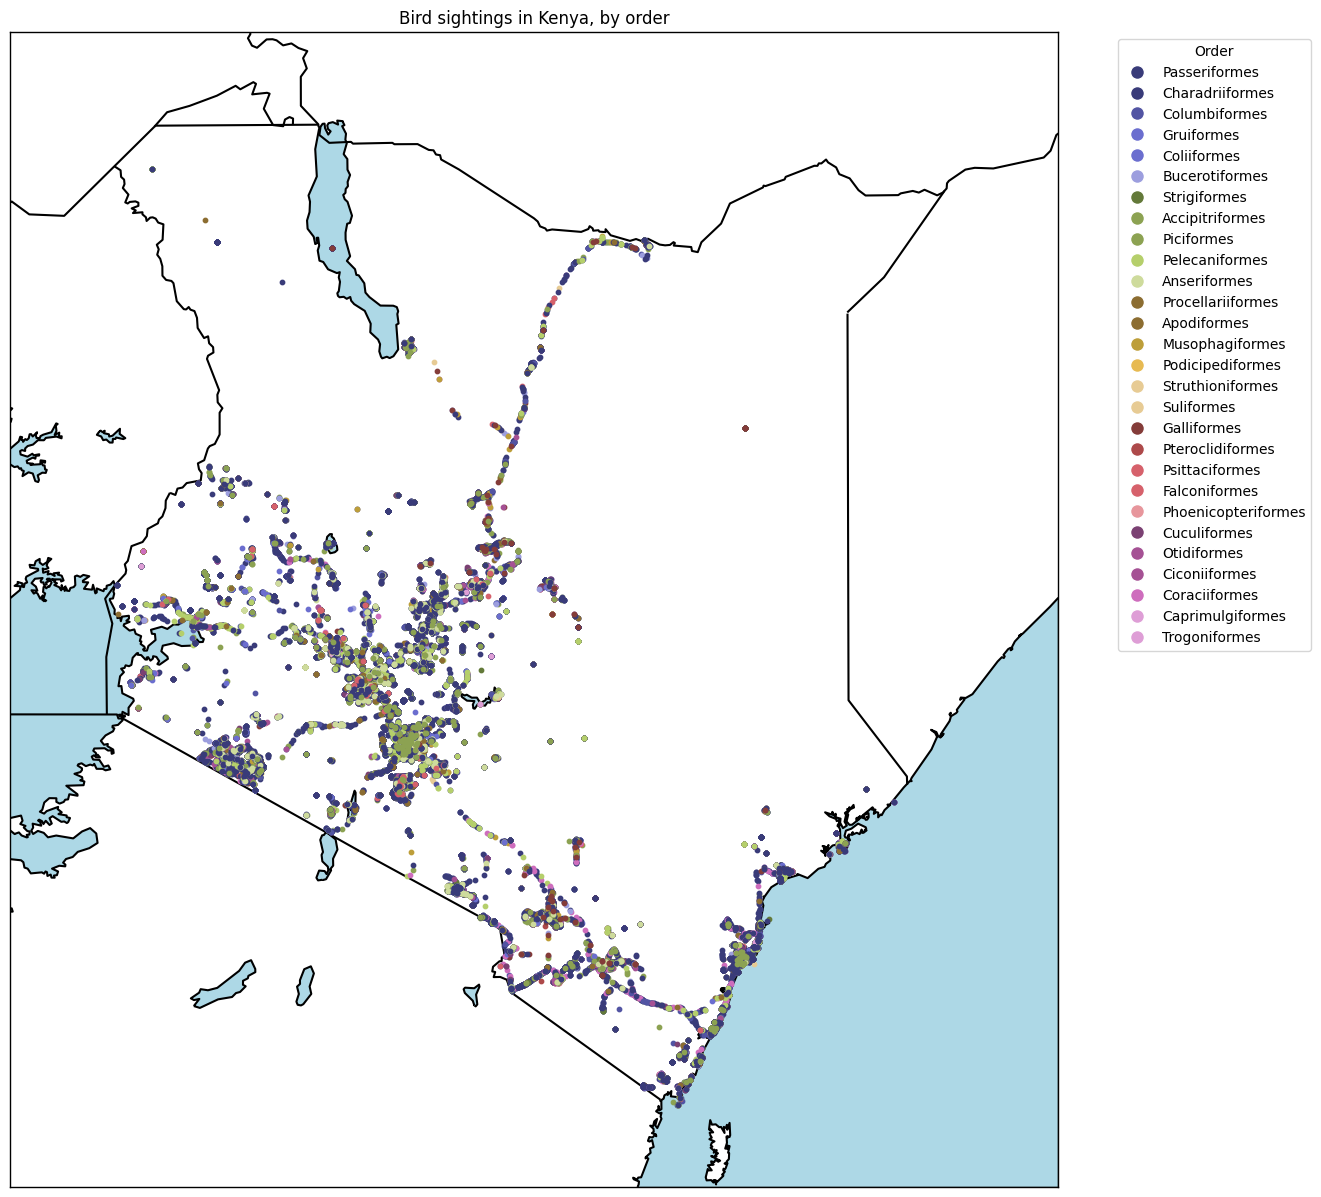

In [15]:
plt.figure(figsize=(20, 15))
m = Basemap(projection='merc',
            llcrnrlat=-5.5, urcrnrlat=5.5,  # Latitude limits
            llcrnrlon=33, urcrnrlon=43,  # Longitude limits
            resolution='i')

m.drawmapboundary(fill_color='lightblue')  # Ocean color
m.fillcontinents(color='white', lake_color='lightblue')  # Land color
m.drawcountries(linewidth=1.5, color='black')  # Country boundaries
m.drawcoastlines(linewidth=1.5, color='black')  # Coastline

for index, row in df.iterrows():
    x, y = m(row['decimalLongitude'], row['decimalLatitude'])
    plt.scatter(x, y, marker='o', color=order_color_map[row['order']], zorder=5, label=row['order'], s=10)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=order_color_map[order], markersize=10) for order in unique_orders]
plt.legend(handles, unique_orders, title='Order', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Bird sightings in Kenya, by order')
plt.show()

Interesting pattern going north, turns out it's one of Kenya's national highways, the A2. The other sightings following a line are other major roads. It makes sense since probably much more people take those roads than the smaller ones in the countryside, hence there is more people who could spot birds. Also, these roads are much easier to access than any small road.

There are a lot if sightings by the coast, which does make sense since birds tend to cluster by coasts to look for food.

There is an interesting cluster at the western part of the south border, which turns out to be the Maasai Mara National Reserve.

Apart from that, most sightings were noted at the heart of the country, where most people live (Nairobi, Nakuru, Nyeri), as well as a very tall mountain Kirinyaga, which could potentially be a touristic spot.

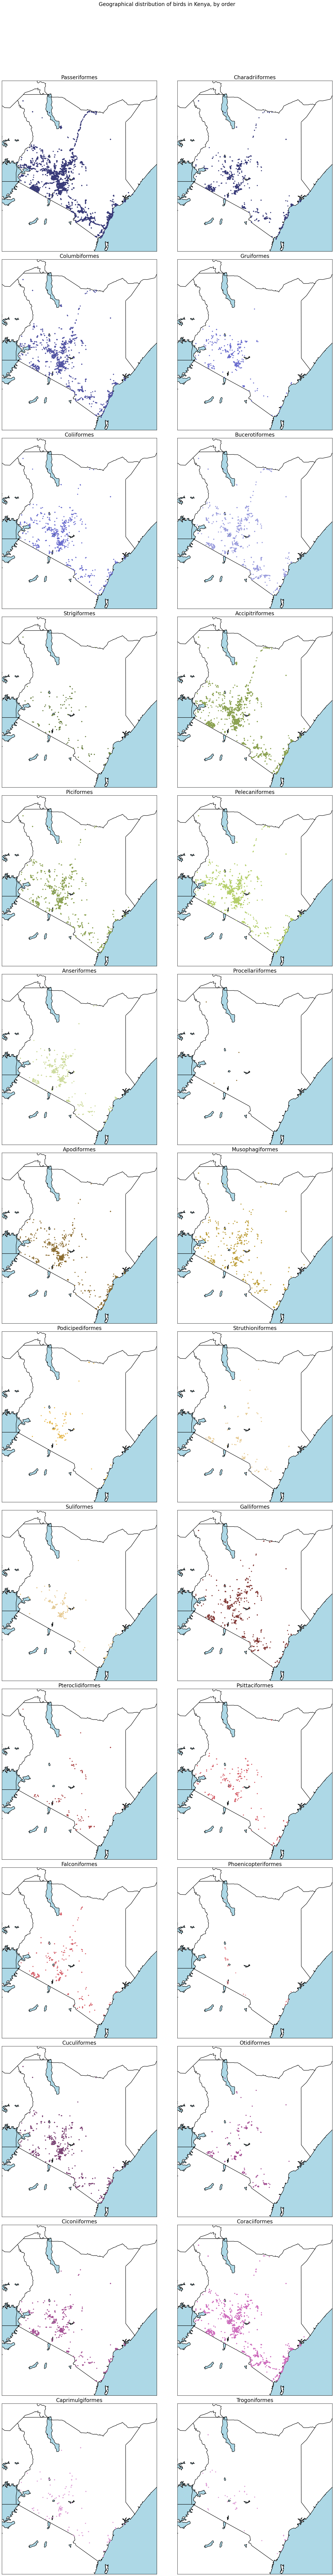

In [16]:
fig, axs = plt.subplots(nrows=14, ncols=2, figsize=(20, 140))
axs = axs.flatten()

for i, order in enumerate(unique_orders):
    df_order = df[df['order'] == order] #.head(100) Limit to the first 100 entries for now

    m = Basemap(projection='merc',
                llcrnrlat=-5.5, urcrnrlat=5.5, 
                llcrnrlon=33, urcrnrlon=43, 
                resolution='i', ax=axs[i])

    m.drawmapboundary(fill_color='lightblue') 
    m.fillcontinents(color='white', lake_color='lightblue') 
    m.drawcountries(linewidth=1.5, color='black') 
    m.drawcoastlines(linewidth=1.5, color='black') 

    if not df_order.empty:  
        x, y = m(df_order['decimalLongitude'].values, df_order['decimalLatitude'].values)
        m.scatter(x, y, marker='o', color=order_color_map[order], zorder=5, s=10)

    # Set the title for the subplot
    axs[i].set_title(order, fontsize=20)

plt.tight_layout()
plt.suptitle('Geographical distribution of birds in Kenya, by order', fontsize=20)
plt.subplots_adjust(top=0.95)
plt.show()

Let's now compute Moran's I to look for clusters:

In [17]:
df['order_encoded'] = pd.factorize(df['order'])[0] + 1

# Create a GeoDataFrame from your DataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['decimalLongitude'], df['decimalLatitude']))

# Loop over different k values and calculate Moran's I for each
results = {}

for k in [3, 5, 7, 10]:
    coords = list(zip(df['decimalLatitude'], df['decimalLongitude']))
    w = KNN.from_array(coords, k=k)
    moran = Moran(df['order_encoded'], w)
    results[k] = {'Morans I': moran.I, 'p-value': moran.p_sim}

for k, result in results.items():
    print(f"For k={k}: Moran's I = {result['Morans I']}, p-value = {result['p-value']}")

/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 4190 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 1535 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 798 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 447 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


For k=3: Moran's I = 0.08096781459266722, p-value = 0.001
For k=5: Moran's I = 0.0742619392740942, p-value = 0.001
For k=7: Moran's I = 0.06814392344015557, p-value = 0.001
For k=10: Moran's I = 0.06450292745925464, p-value = 0.001


The Moran’s I value is positive in all cases, meaning there is positive spatial autocorrelation in the data (similar values are clustered). As $k$ increases, the Moran's I slightly decreases, suggesting that as the neighborhood size increases, the spatial clustering is slightly less pronounced. This could be because the larger neighborhood size is considering more distant points, which might weaken the autocorrelation signal.

Regarding the p-values, it is 0.001 for each $k$, which is very small. This means that the spatial autocorrelation is highly significant, and it is unlikely to be due to random chance.

Now, let's compute the same numbers but for each order individually:

In [18]:
# Convert the DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

unique_orders = gdf['order'].unique()
moran_results = {}

k = 3

# Calculate Moran's I for each bird order using KNN
for order in unique_orders:
    gdf_order = gdf[gdf['order'] == order]
    if len(gdf_order) > k:
        w_loc = KNN.from_dataframe(gdf_order, k=k)
        w_loc.transform = "R"
        
        mi = Moran(gdf_order['individualCount'], w_loc)
        moran_results[order] = {'Moran I': mi.I, 'p-value': mi.p_sim}
    else:
        moran_results[order] = {'Moran I': None, 'p-value': None, 'Note': 'Insufficient data for KNN'}

moran_df = pd.DataFrame(moran_results).T
moran_df

/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2347 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 285 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 272 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 55 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights m

Moran I  p-value
Passeriformes        0.039822    0.001
Charadriiformes      0.037294    0.009
Columbiformes        0.272881    0.001
Gruiformes           0.709706    0.001
Coliiformes          0.406341    0.001
Bucerotiformes       0.255288    0.001
Strigiformes        -0.006033    0.273
Accipitriformes      0.090690    0.001
Piciformes           0.231347    0.001
Pelecaniformes       0.026131    0.007
Anseriformes         0.046352    0.024
Procellariiformes         NaN    0.001
Apodiformes          0.048812    0.009
Musophagiformes      0.292696    0.001
Podicipediformes     0.724140    0.001
Struthioniformes     0.084194    0.019
Suliformes           0.066809    0.021
Galliformes          0.265947    0.001
Pteroclidiformes     0.161851    0.014
Psittaciformes       0.130503    0.011
Falconiformes        0.021935    0.068
Phoenicopteriformes  0.001976    0.135
Cuculiformes         0.192941    0.001
Otidiformes          0.147010    0.007
Ciconiiformes        0.014537    0.054
Coraciiformes        0.139322    0.001
Caprimulgiformes    -0.015152    0.332
Trogoniformes       -0.047893    0.284

Let's try with different k-values:

In [19]:
geometry = [Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

unique_orders = gdf['order'].unique()

moran_results = {}

k_values = [3, 5, 7, 10]

for order in unique_orders:
    gdf_order = gdf[gdf['order'] == order]
    moran_results[order] = {}
    
    if len(gdf_order) > max(k_values):
        for k in k_values:
            w_loc = KNN.from_dataframe(gdf_order, k=k)
            w_loc.transform = "R"
            mi = Moran(gdf_order['individualCount'], w_loc)
            moran_results[order][k] = {'Moran I': mi.I, 'p-value': mi.p_sim}
    else:
        moran_results[order] = {k: {'Moran I': None, 'p-value': None, 'Note': 'Insufficient data for KNN'} for k in k_values}

moran_df = pd.DataFrame.from_dict({(order, k): moran_results[order][k] 
                                   for order in moran_results for k in moran_results[order]},
                                  orient='index')
moran_df.index.names = ['Order', 'k']
moran_df.to_csv('moran_results.csv')
moran_df

/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2347 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 895 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 503 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 316 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/usr/local/lib/python3.10/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights 

Moran I  p-value Note
Order            k                         
Passeriformes    3   0.039822    0.003  NaN
                 5   0.043922    0.001  NaN
                 7   0.043732    0.001  NaN
                 10  0.042056    0.001  NaN
Charadriiformes  3   0.037294    0.012  NaN
...                       ...      ...  ...
Caprimulgiformes 10  0.055195    0.024  NaN
Trogoniformes    3  -0.047893    0.270  NaN
                 5  -0.035632    0.338  NaN
                 7   0.057635    0.060  NaN
                 10  0.154713    0.003  NaN

[112 rows x 3 columns]

The spatial clustering analysis of bird orders in Kenya was conducted using Moran’s I across different neighborhood sizes ($k$ = 3, 5, 7, 10). Positive and significant Moran’s I values indicate spatial clustering, while negative or near-zero values suggest random distribution or dispersion.


- **Consistent Clustering Across Scales:**
  - Orders such as **Gruiformes** and **Podicipediformes** exhibited high Moran's I values across all $k$ values, suggesting strong spatial clustering. This pattern implies that these orders are likely associated with specific habitats and tend to cluster within localized regions.
  - **Galliformes** and **Coraciiformes** maintained positive Moran's I values across increasing $k$, indicating clustering at both local and broader scales. This suggests that these orders may prefer widespread habitat types or regions within the country.

- **Scale-Dependent Clustering:**
  - Several orders, including **Columbiformes** and **Musophagiformes**, showed decreasing Moran's I values as $k$ increased, highlighting that clustering is most pronounced at smaller spatial scales. These orders are likely associated with localized habitats or regions.
  - **Pelecaniformes** and **Psittaciformes** demonstrated varying Moran’s I values across $k$, suggesting clustering patterns that may be sensitive to spatial scale. This could indicate mixed habitat use or moderate mobility across different regions.

- **Random or Dispersed Patterns:**
  - Orders such as **Strigiformes** and **Caprimulgiformes** had Moran’s I values close to zero or slightly negative with high p-values, indicating a lack of significant spatial autocorrelation. This suggests that these orders are either randomly distributed or dispersed, potentially indicating broader habitat tolerance.

- **Insufficient Data:**
  - Certain orders, such as **Procellariiformes**, had insufficient data for Moran's I calculation at larger $k$ values, likely due to limited sightings. These cases indicate areas where additional data may be required for reliable spatial analysis.

The analysis reveals that many bird orders in Kenya exhibit spatial clustering, particularly at smaller neighborhood sizes, indicating habitat-specific clustering patterns. Orders with consistent clustering across scales likely prefer widespread environments, while others exhibit more localized clustering, suggesting habitat specialization. Orders with dispersed or random patterns may represent generalist species distributed across a range of habitats.


In [20]:
moran_df = pd.read_csv('moran_results.csv')
moran_df.head()

Order   k   Moran I  p-value Note
0    Passeriformes   3  0.039822    0.003  NaN
1    Passeriformes   5  0.043922    0.001  NaN
2    Passeriformes   7  0.043732    0.001  NaN
3    Passeriformes  10  0.042056    0.001  NaN
4  Charadriiformes   3  0.037294    0.012  NaN

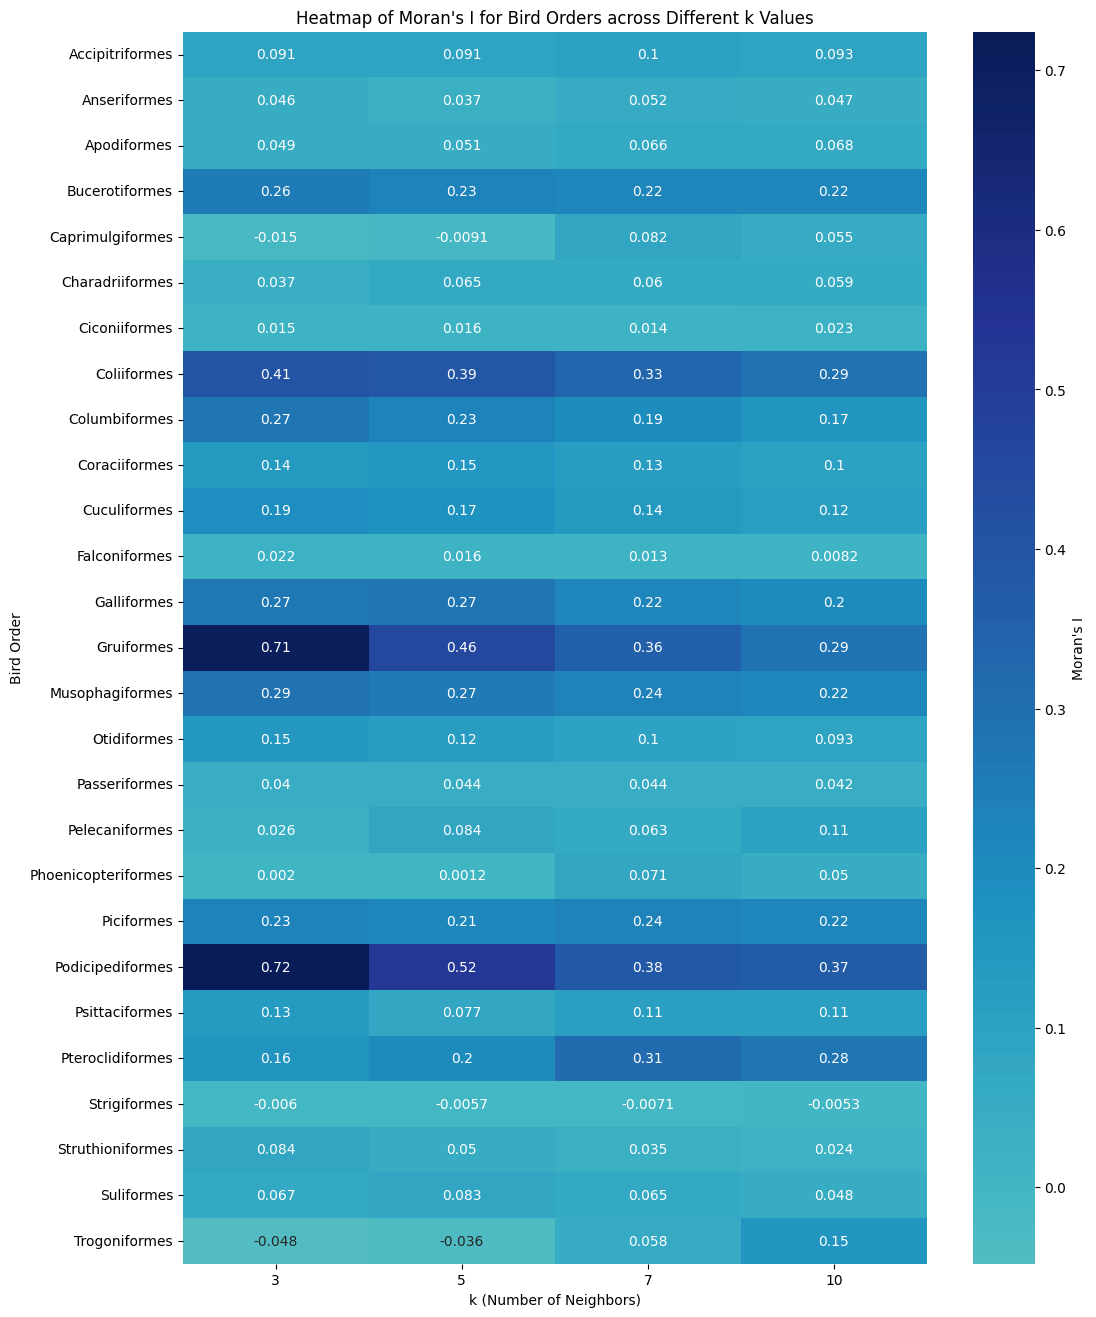

In [21]:
data = moran_df

filtered_data = data.dropna(subset=['Moran I', 'p-value'])
heatmap_data = filtered_data.pivot(index="Order", columns="k", values="Moran I")

# Plotting the heatmap
plt.figure(figsize=(12, 16))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", center=0, cbar_kws={'label': "Moran's I"})
plt.title("Heatmap of Moran's I for Bird Orders across Different k Values")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Bird Order")
plt.show()


Now, let's try to cluster these points:

/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_44480/3131873814.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_colors = plt.cm.get_cmap('tab10', len(unique_clusters))


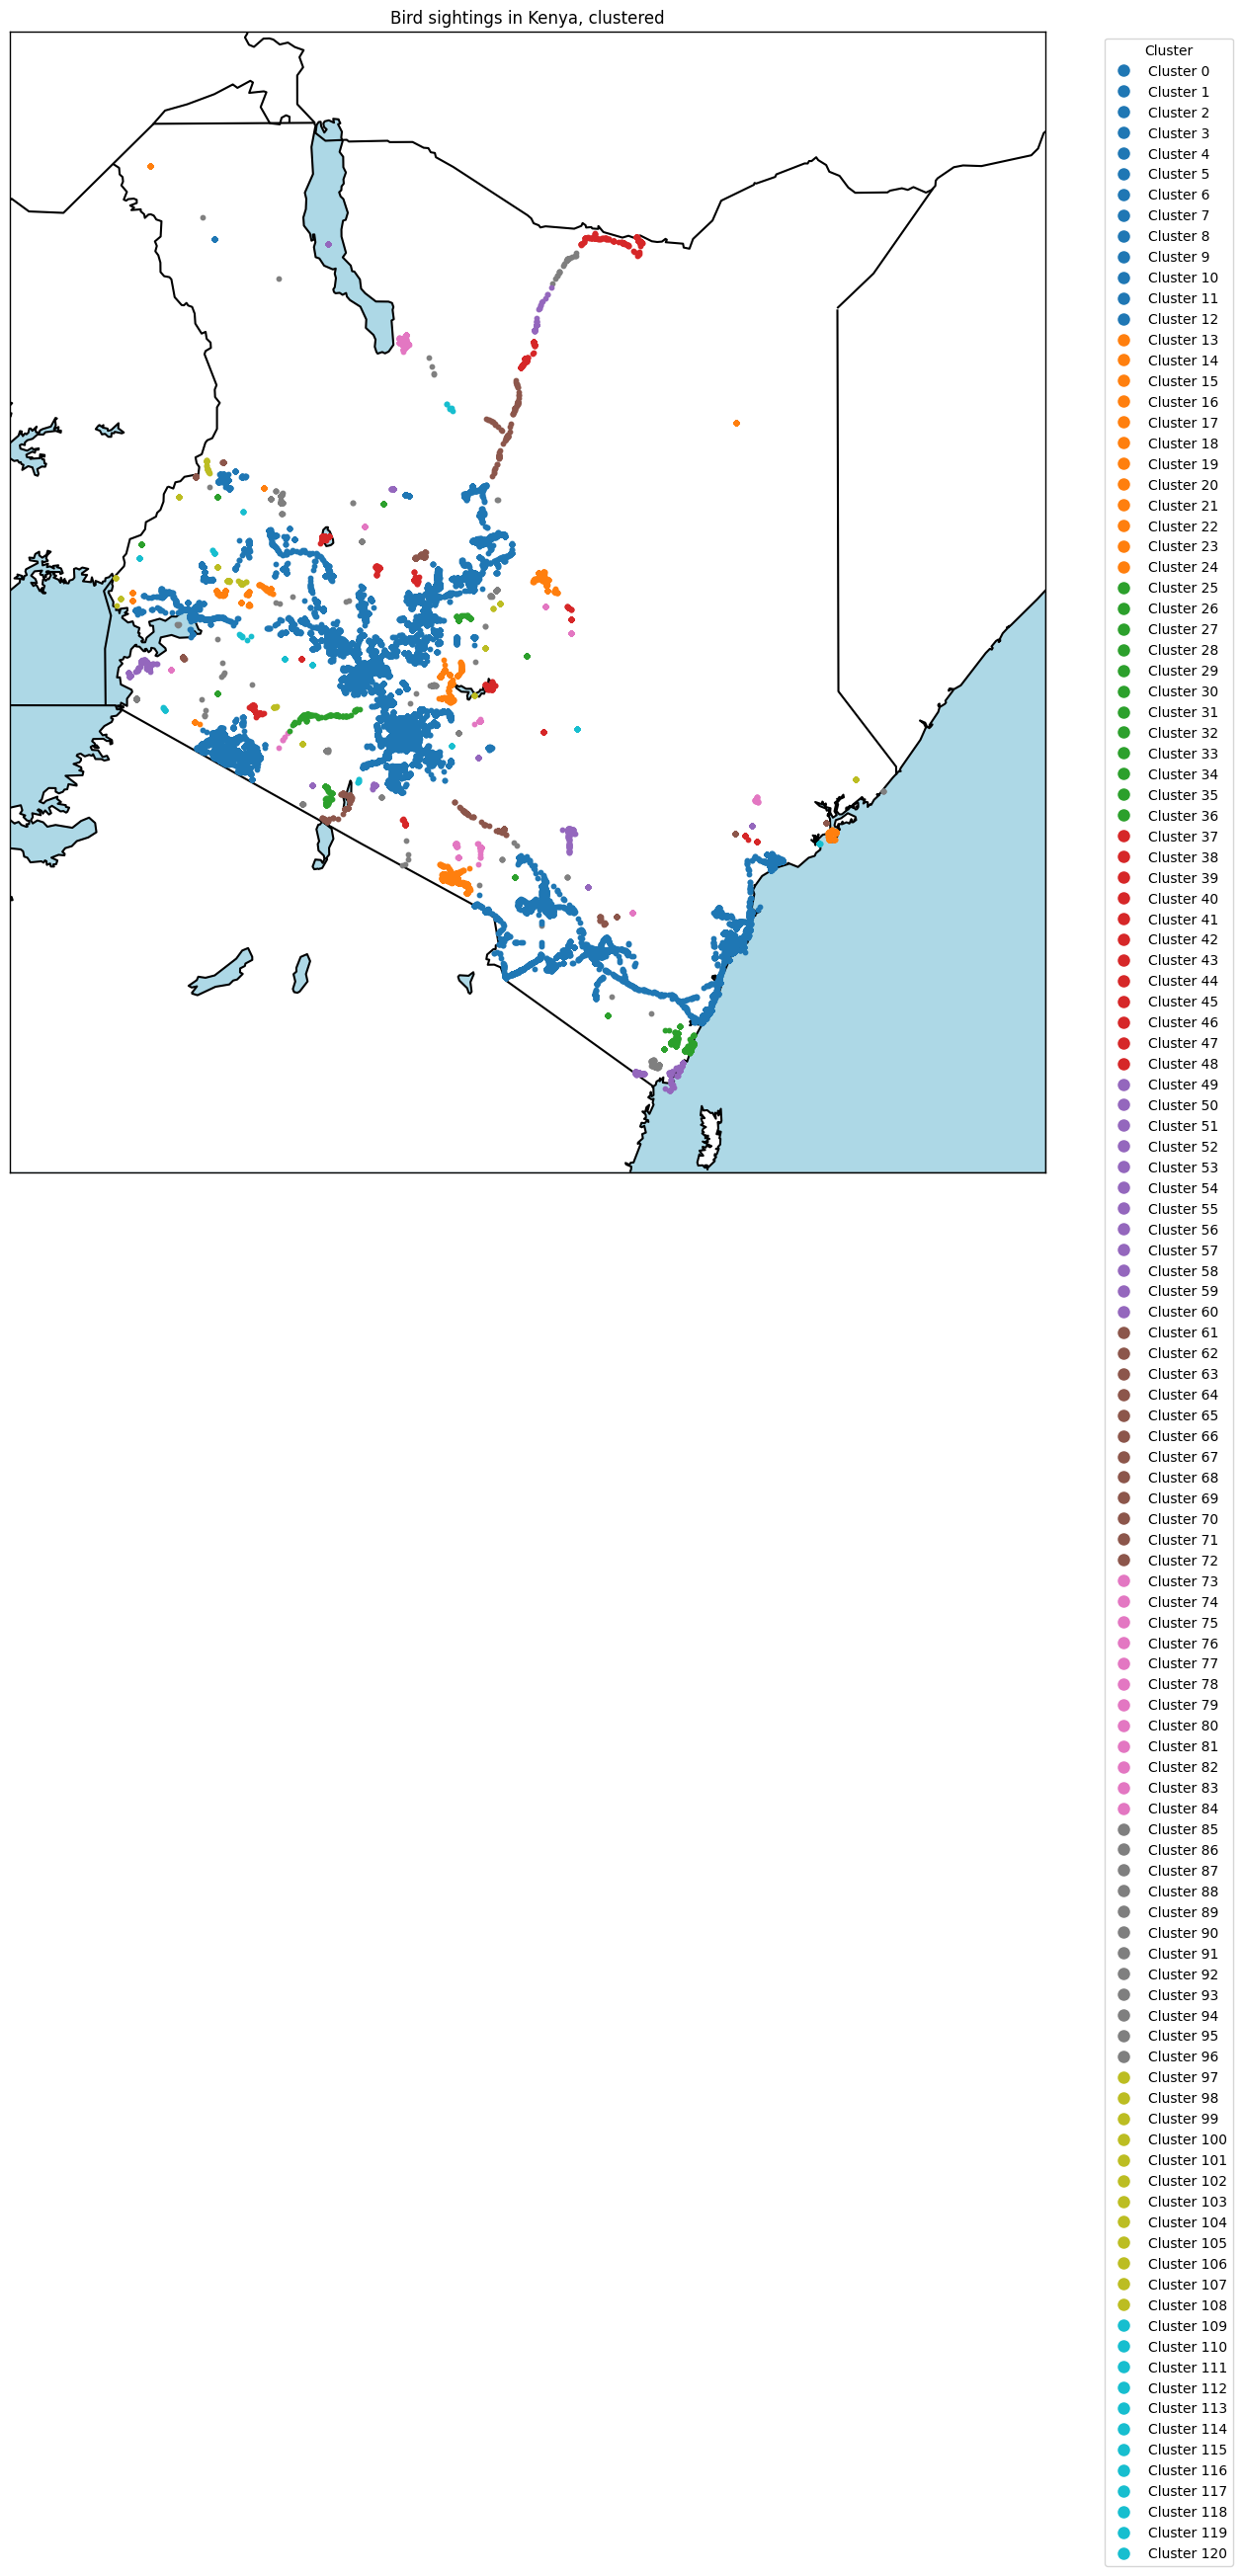

In [22]:
coordinates = np.array([m(row['decimalLongitude'], row['decimalLatitude']) for _, row in df.iterrows()])

# Apply DBSCAN
db = DBSCAN(eps=10000, min_samples=5)
labels = db.fit_predict(coordinates)

# Add cluster labels to the DataFrame
df['cluster'] = labels

plt.figure(figsize=(20, 15))
m = Basemap(projection='merc',
            llcrnrlat=-5.5, urcrnrlat=5.5,
            llcrnrlon=33, urcrnrlon=43,
            resolution='i')

m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='white', lake_color='lightblue')
m.drawcountries(linewidth=1.5, color='black')
m.drawcoastlines(linewidth=1.5, color='black')

# Plot each point, colored by cluster
unique_clusters = df['cluster'].unique()
cluster_colors = plt.cm.get_cmap('tab10', len(unique_clusters)) 

for index, row in df.iterrows():
    x, y = m(row['decimalLongitude'], row['decimalLatitude'])
    cluster_label = row['cluster']
    color = 'gray' if cluster_label == -1 else cluster_colors(cluster_label) 
    plt.scatter(x, y, marker='o', color=color, zorder=5, s=10)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_colors(i), markersize=10) 
           for i in range(len(unique_clusters)) if i != -1]
plt.legend(handles, [f'Cluster {i}' for i in unique_clusters if i != -1], title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Bird sightings in Kenya, clustered')
plt.show()

/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_44480/3538908887.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_colors = plt.cm.get_cmap('tab10', len(unique_clusters))


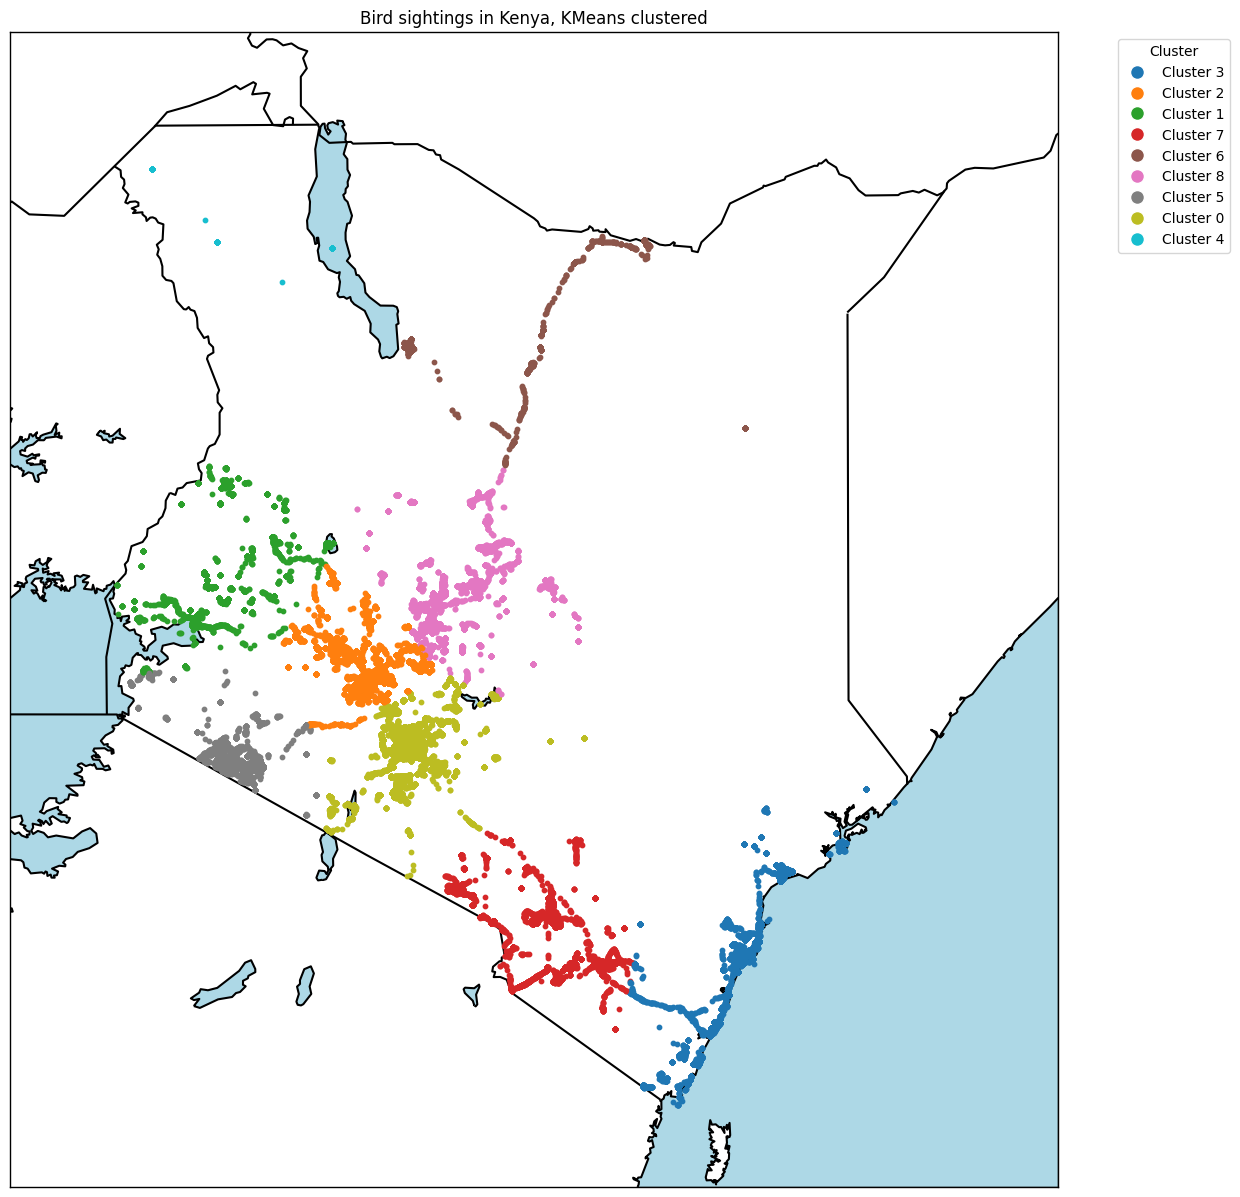

In [23]:
m = Basemap(projection='merc',
            llcrnrlat=-5.5, urcrnrlat=5.5, 
            llcrnrlon=33, urcrnrlon=43, 
            resolution='i')

coordinates = np.array([m(row['decimalLongitude'], row['decimalLatitude']) for _, row in df.iterrows()])

kmeans = KMeans(n_clusters=9, random_state=0)
df['cluster'] = kmeans.fit_predict(coordinates)

plt.figure(figsize=(20, 15))

m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='white', lake_color='lightblue')
m.drawcountries(linewidth=1.5, color='black')
m.drawcoastlines(linewidth=1.5, color='black')

# Plot each point, colored by cluster
unique_clusters = df['cluster'].unique()
cluster_colors = plt.cm.get_cmap('tab10', len(unique_clusters)) 

for index, row in df.iterrows():
    x, y = m(row['decimalLongitude'], row['decimalLatitude'])
    cluster_label = row['cluster']
    color = cluster_colors(cluster_label)
    plt.scatter(x, y, marker='o', color=color, zorder=5, s=10)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_colors(i), markersize=10) 
           for i in range(len(unique_clusters))]
plt.legend(handles, [f'Cluster {i}' for i in unique_clusters], title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Bird sightings in Kenya, KMeans clustered')
plt.show()

### Question 2

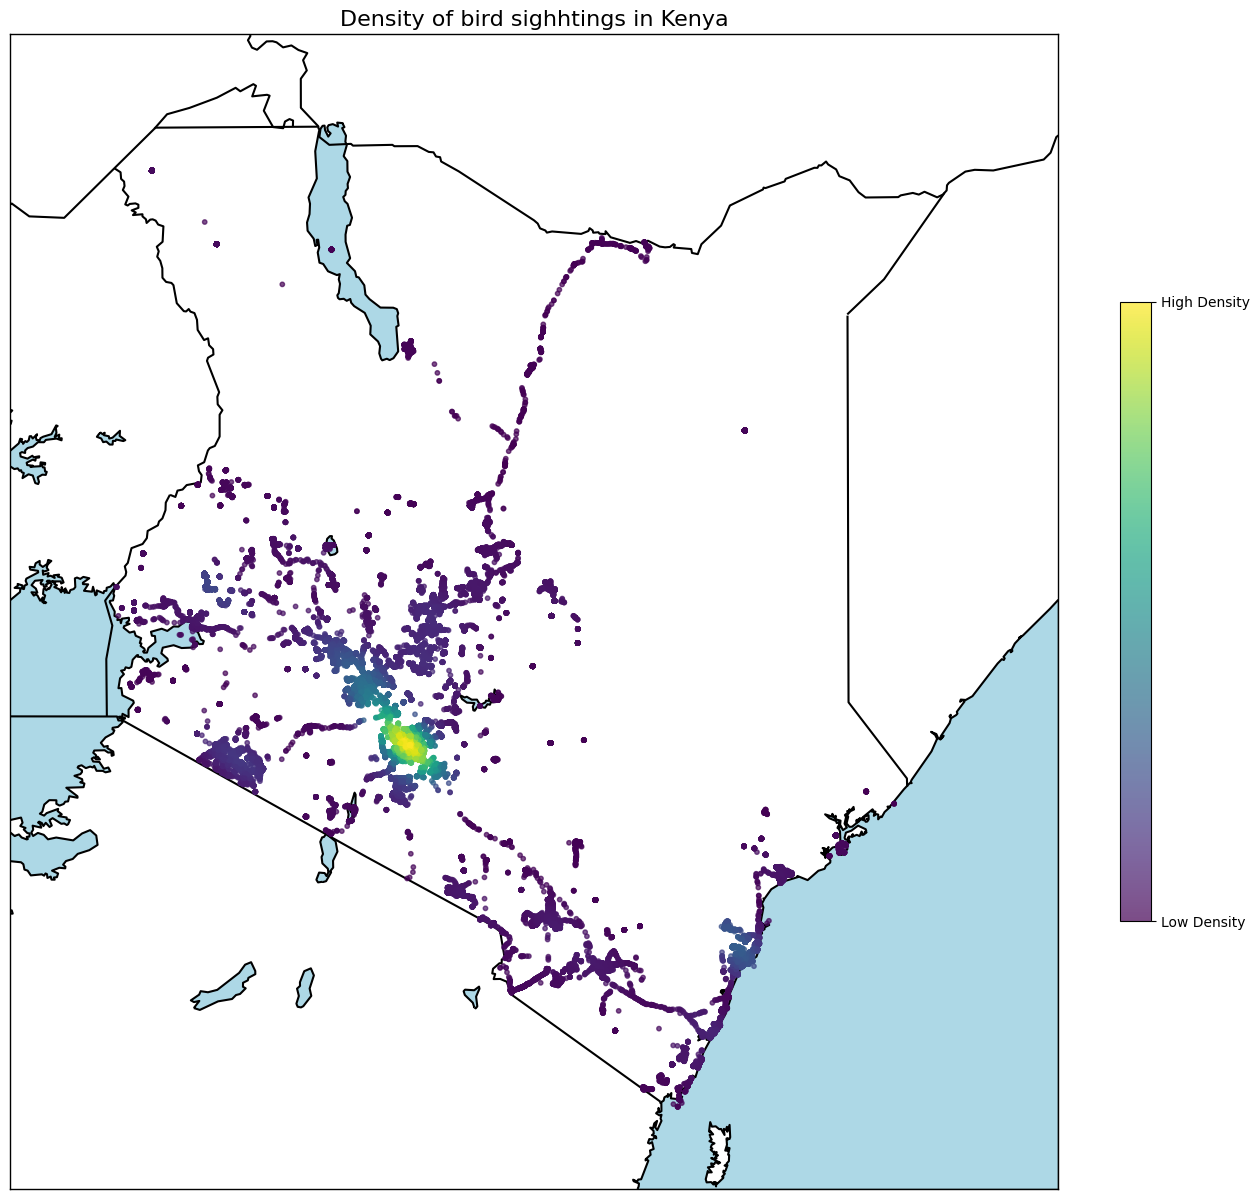

In [24]:
plt.figure(figsize=(20, 15))
m = Basemap(projection='merc',
            llcrnrlat=-5.5, urcrnrlat=5.5, 
            llcrnrlon=33, urcrnrlon=43, 
            resolution='i')

m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='white', lake_color='lightblue') 
m.drawcountries(linewidth=1.5, color='black') 
m.drawcoastlines(linewidth=1.5, color='black') 

latitudes = df['decimalLatitude'].values
longitudes = df['decimalLongitude'].values

lon_grid = np.linspace(33, 43, 100)  
lat_grid = np.linspace(-5.5, 5.5, 100) 
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# Flatten the grid to evaluate the density
positions = np.vstack([lon_mesh.ravel(), lat_mesh.ravel()])
values = np.vstack([longitudes, latitudes])

# Create a Gaussian KDE
kde = gaussian_kde(values)

# Evaluate the density on the grid
density = kde(positions).reshape(lon_mesh.shape)

# Normalize the density for colormap
density_normalized = (density - density.min()) / (density.max() - density.min())
cmap = plt.get_cmap('viridis')

# Calculate the density value for each point and map to colors
point_density = kde(np.vstack([longitudes, latitudes]))
colors = cmap((point_density - point_density.min()) / (point_density.max() - point_density.min()))

x_points, y_points = m(longitudes, latitudes)
scatter = m.scatter(x_points, y_points, marker='o', color=colors, zorder=5, alpha=0.7, s=10)

cbar = plt.colorbar(scatter, orientation='vertical', fraction=0.02, pad=0.04)

cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Low Density', 'High Density'])

plt.title('Density of bird sighhtings in Kenya', fontsize=16)
plt.show()

let's consider individualCount as weight of each sighting so that a higher count contributes more heavily to the density

now, that column has 80 missing values, so let's first handle those:

In [25]:
df['individualCount'].describe()

count    89447.000000
mean         2.082608
std         34.505889
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       7000.000000
Name: individualCount, dtype: float64

we see that apart from some outliers, most counts are quite small and the median is 1. Let's replace all missing values with the median:

In [26]:
df['individualCount'].fillna(df['individualCount'].median(), inplace=True)

/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_44480/3443841734.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['individualCount'].fillna(df['individualCount'].median(), inplace=True)


In [27]:
df['individualCount'].isnull().sum()

0

all good to proceed

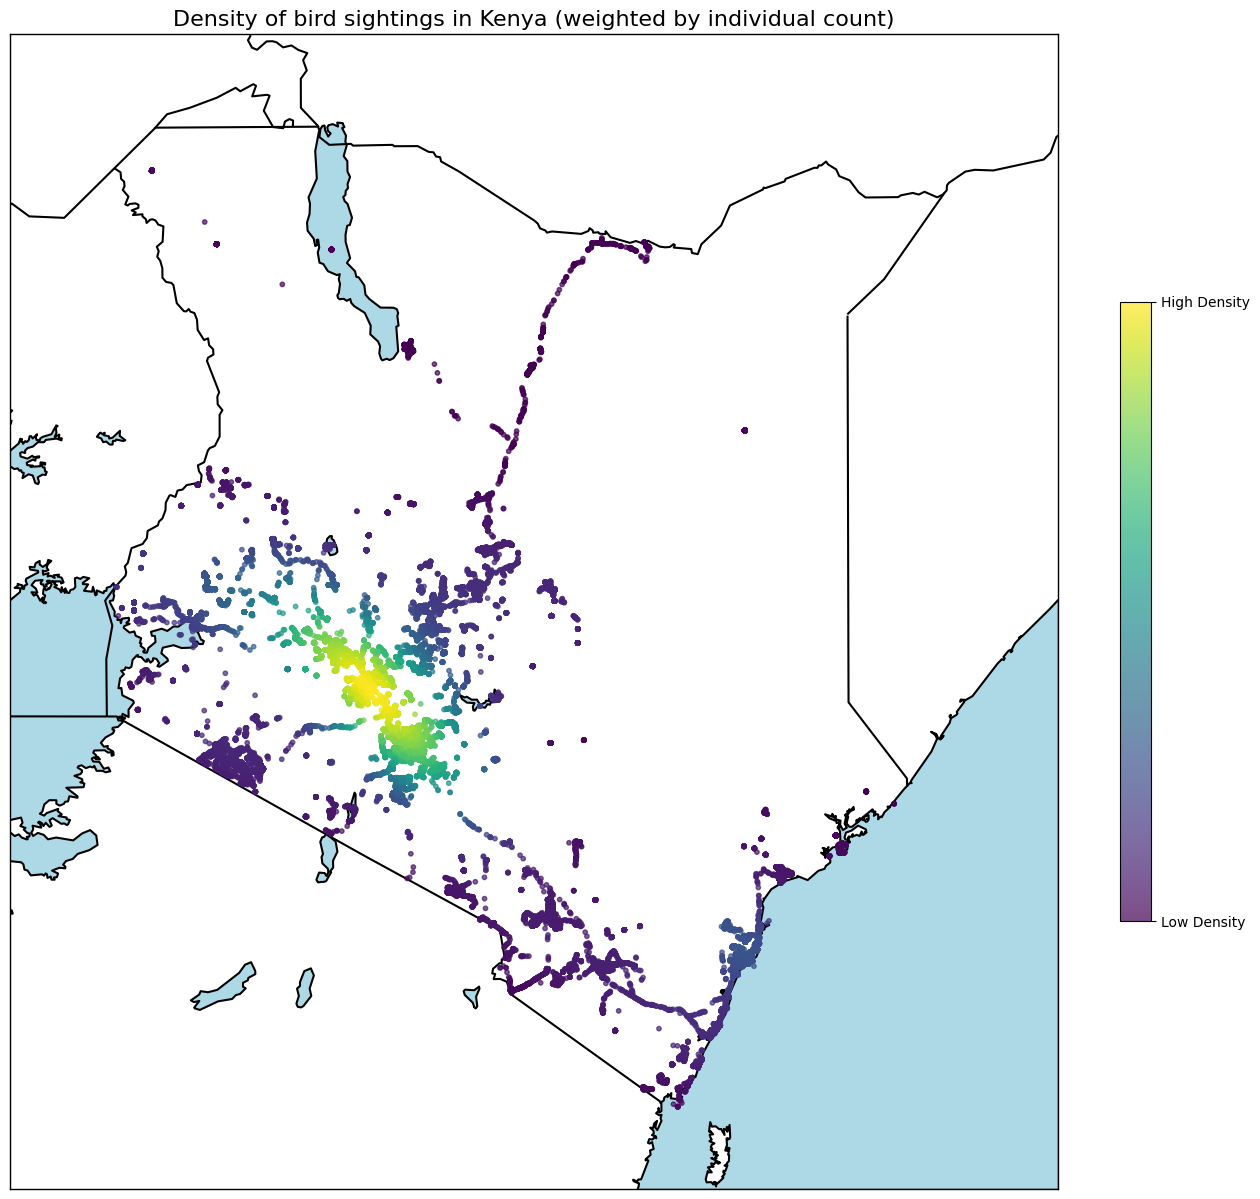

In [28]:
plt.figure(figsize=(20, 15))
m = Basemap(projection='merc',
            llcrnrlat=-5.5, urcrnrlat=5.5, 
            llcrnrlon=33, urcrnrlon=43, 
            resolution='i')

m.drawmapboundary(fill_color='lightblue') 
m.fillcontinents(color='white', lake_color='lightblue') 
m.drawcountries(linewidth=1.5, color='black') 
m.drawcoastlines(linewidth=1.5, color='black') 

latitudes = df['decimalLatitude'].values
longitudes = df['decimalLongitude'].values
individual_counts = df['individualCount'].values 

lon_grid = np.linspace(33, 43, 100)  
lat_grid = np.linspace(-5.5, 5.5, 100)  
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

positions = np.vstack([lon_mesh.ravel(), lat_mesh.ravel()])
values = np.vstack([longitudes, latitudes])

kde = gaussian_kde(values, weights=individual_counts)

density = kde(positions).reshape(lon_mesh.shape)

density_normalized = (density - density.min()) / (density.max() - density.min())
cmap = plt.get_cmap('viridis')

point_density = kde(np.vstack([longitudes, latitudes]))
colors = cmap((point_density - point_density.min()) / (point_density.max() - point_density.min()))

x_points, y_points = m(longitudes, latitudes)
scatter = m.scatter(x_points, y_points, marker='o', color=colors, zorder=5, alpha=0.7, s=10)

cbar = plt.colorbar(scatter, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Low Density', 'High Density'])

plt.title('Density of bird sightings in Kenya (weighted by individual count)', fontsize=16)
plt.show()

yep big difference

### Question 3

For Question3 we need to add external datasets. Here is a list of useful Datasets:

- USGS EarthExplorer
https://earthexplorer.usgs.gov/

- WorldClim
    https://www.worldclim.org/
    => Historical climate data

- ESA WorldCover
    - https://modis.gsfc.nasa.gov/data/dataprod/mod12.php => https://lpdaac.usgs.gov/products/mcd12q1v061/

    - https://esa-worldcover.org/en


- Dynamic World
https://www.dynamicworld.app/

- https://www.un-spider.org/links-and-resources/data-sources/land-cover-kenya-africover-fao


- HydroSHEDS
https://www.hydrosheds.org/

After careful consideration in datasets, their quality and size we chose, WorldClim data 

In [29]:
occurrence_path = './data/GBIT_annotated_archive/DARWIN_CORE_ARCHIVE/0020723-241024112534372/occurrence.txt'
elevation_path = './data/Extra/wc2.1_30s_elev.tif'
monthly_precip_files = [
    f'./data/Extra/wc2.1_30s_prec/wc2.1_30s_prec_{str(i).zfill(2)}.tif' for i in range(1, 13)
]

In [30]:
print("Loading bird occurrence data...")
occurrence_data = pd.read_csv(occurrence_path, delimiter='\t')
occurrence_data = occurrence_data[occurrence_data['countryCode'] == 'KE']

geometry = [Point(xy) for xy in zip(occurrence_data['decimalLongitude'], occurrence_data['decimalLatitude'])]
occurrence_gdf = gpd.GeoDataFrame(occurrence_data, geometry=geometry, crs="EPSG:4326")
print("Bird occurrence data loaded and converted to GeoDataFrame.")

Loading bird occurrence data...


/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_44480/2522563547.py:2: DtypeWarning: Columns (170) have mixed types. Specify dtype option on import or set low_memory=False.
  occurrence_data = pd.read_csv(occurrence_path, delimiter='\t')


Bird occurrence data loaded and converted to GeoDataFrame.


In [31]:
# Remove rows with NaN values in the individualCount column
occurrence_gdf.dropna(subset=['individualCount'], inplace=True)

In [32]:
occurrence_gdf['individualCount'].describe()

count    89552.000000
mean         2.081472
std         34.485674
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       7000.000000
Name: individualCount, dtype: float64

Given that the majority of counts are 1, but there are extreme values (up to 7,000), this variable has a highly skewed distribution. Most observations are small, with a few very large counts likely contributing to the high mean and standard deviation.

In [33]:
# Apply log transformation
occurrence_gdf['log_individualCount'] = np.log1p(occurrence_gdf['individualCount'])

# Check the distribution after transformation
occurrence_gdf['log_individualCount'].describe()

count    89552.000000
mean         0.840928
std          0.422653
min          0.693147
25%          0.693147
50%          0.693147
75%          0.693147
max          8.853808
Name: log_individualCount, dtype: float64

We used Log Transformation to retain all data points but reduce skewness. This approach is suitable for correlation analyses, where high values would otherwise dominate the results.
it is ideal for preserving the full dataset while making the distribution more normally distributed.

In [34]:
# Extract elevation values for each bird observation point
print("Extracting elevation values for each bird observation point...")
coordinates = [(x, y) for x, y in zip(occurrence_gdf['decimalLongitude'], occurrence_gdf['decimalLatitude'])]
with rasterio.open(elevation_path) as elev_raster:
    elevation_values = [val[0] if val else np.nan for val in elev_raster.sample(coordinates)]
occurrence_gdf['elevation'] = elevation_values
print("Elevation values extracted and added to GeoDataFrame.")

Extracting elevation values for each bird observation point...
Elevation values extracted and added to GeoDataFrame.


In [35]:
occurrence_gdf['elevation'].describe()

count    89516.000000
mean      1229.689586
std       2660.901777
min     -32768.000000
25%        978.000000
50%       1668.000000
75%       1870.000000
max       4738.000000
Name: elevation, dtype: float64

In [36]:
print("Unique values near the extremes:")
print(occurrence_gdf['elevation'].value_counts().sort_index().head(10))  # Check low values
print(occurrence_gdf['elevation'].value_counts().sort_index(ascending=False).head(10))  # Check high values

Unique values near the extremes:
elevation
-32768.0    504
-1.0         33
 1.0         75
 2.0        674
 3.0        773
 4.0         75
 5.0        130
 6.0        256
 7.0        651
 8.0        137
Name: count, dtype: int64
elevation
4738.0      1
4361.0    216
4310.0      2
4264.0      5
4166.0      3
4137.0     54
4019.0      1
3763.0      1
3509.0      1
3313.0      3
Name: count, dtype: int64


In [37]:
# Replace No-Data values (-32768) in 'elevation' with NaN
no_data_values = [-32768]
occurrence_gdf['elevation'] = occurrence_gdf['elevation'].replace(no_data_values, np.nan)

occurrence_gdf.dropna(subset=['decimalLongitude', 'decimalLatitude', 'elevation', 'individualCount', 'log_individualCount'], inplace=True)

Q1 = occurrence_gdf['elevation'].quantile(0.25)
Q3 = occurrence_gdf['elevation'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

occurrence_gdf = occurrence_gdf[
    (occurrence_gdf['elevation'] >= lower_bound) & 
    (occurrence_gdf['elevation'] <= upper_bound)
]

print("Final data description after No-Data handling and IQR filtering:")
print(occurrence_gdf[['elevation', 'individualCount', 'log_individualCount']].describe())

Final data description after No-Data handling and IQR filtering:
          elevation  individualCount  log_individualCount
count  88698.000000     88698.000000         88698.000000
mean    1412.340391         2.075379             0.841080
std      716.095101        34.516902             0.422687
min       -1.000000         1.000000             0.693147
25%      987.000000         1.000000             0.693147
50%     1669.000000         1.000000             0.693147
75%     1868.000000         1.000000             0.693147
max     3191.000000      7000.000000             8.853808


In [38]:
print("Extracting monthly precipitation values for each point and calculating the average...")

# Remove 'average_precipitation' column if it already exists
if 'average_precipitation' in occurrence_gdf.columns:
    occurrence_gdf = occurrence_gdf.drop(columns=['average_precipitation'])

coordinates = [(x, y) for x, y in zip(occurrence_gdf['decimalLongitude'], occurrence_gdf['decimalLatitude'])]

# Prepare to extract monthly precipitation values for each point
monthly_precip_values = []
for i, file in enumerate(monthly_precip_files, 1):
    print(f"Processing precipitation data for month {i}...")
    with rasterio.open(file) as src:
        monthly_values = [val[0] if val else np.nan for val in src.sample(coordinates)]
        monthly_precip_values.append(monthly_values)

monthly_precip_array = np.array(monthly_precip_values)
average_precipitation = np.nanmean(monthly_precip_array, axis=0)

occurrence_gdf['average_precipitation'] = average_precipitation
print("Average precipitation calculated and added to GeoDataFrame.")

occurrence_gdf.dropna(subset=['elevation', 'individualCount', 'log_individualCount', 'average_precipitation', 'decimalLongitude', 'decimalLatitude'], inplace=True)

Extracting monthly precipitation values for each point and calculating the average...
Processing precipitation data for month 1...
Processing precipitation data for month 2...
Processing precipitation data for month 3...
Processing precipitation data for month 4...
Processing precipitation data for month 5...
Processing precipitation data for month 6...
Processing precipitation data for month 7...
Processing precipitation data for month 8...
Processing precipitation data for month 9...
Processing precipitation data for month 10...
Processing precipitation data for month 11...
Processing precipitation data for month 12...
Average precipitation calculated and added to GeoDataFrame.


In [39]:
occurrence_gdf[['elevation', 'individualCount', 'log_individualCount', 'average_precipitation', 'decimalLongitude', 'decimalLatitude']].describe()

elevation  individualCount  log_individualCount  \
count  88698.000000     88698.000000         88698.000000   
mean    1412.340391         2.075379             0.841080   
std      716.095101        34.516902             0.422687   
min       -1.000000         1.000000             0.693147   
25%      987.000000         1.000000             0.693147   
50%     1669.000000         1.000000             0.693147   
75%     1868.000000         1.000000             0.693147   
max     3191.000000      7000.000000             8.853808   

       average_precipitation  decimalLongitude  decimalLatitude  
count           88698.000000      88698.000000     88698.000000  
mean               80.355600         37.019604        -1.191223  
std                25.953202          1.516482         1.411316  
min                14.083333         34.016667        -4.683672  
25%                63.583333         36.250000        -1.634374  
50%                76.833333         36.798743        -1.235306  
75%                90.583333         37.505857        -0.339102  
max               167.583333         41.166667         4.201833

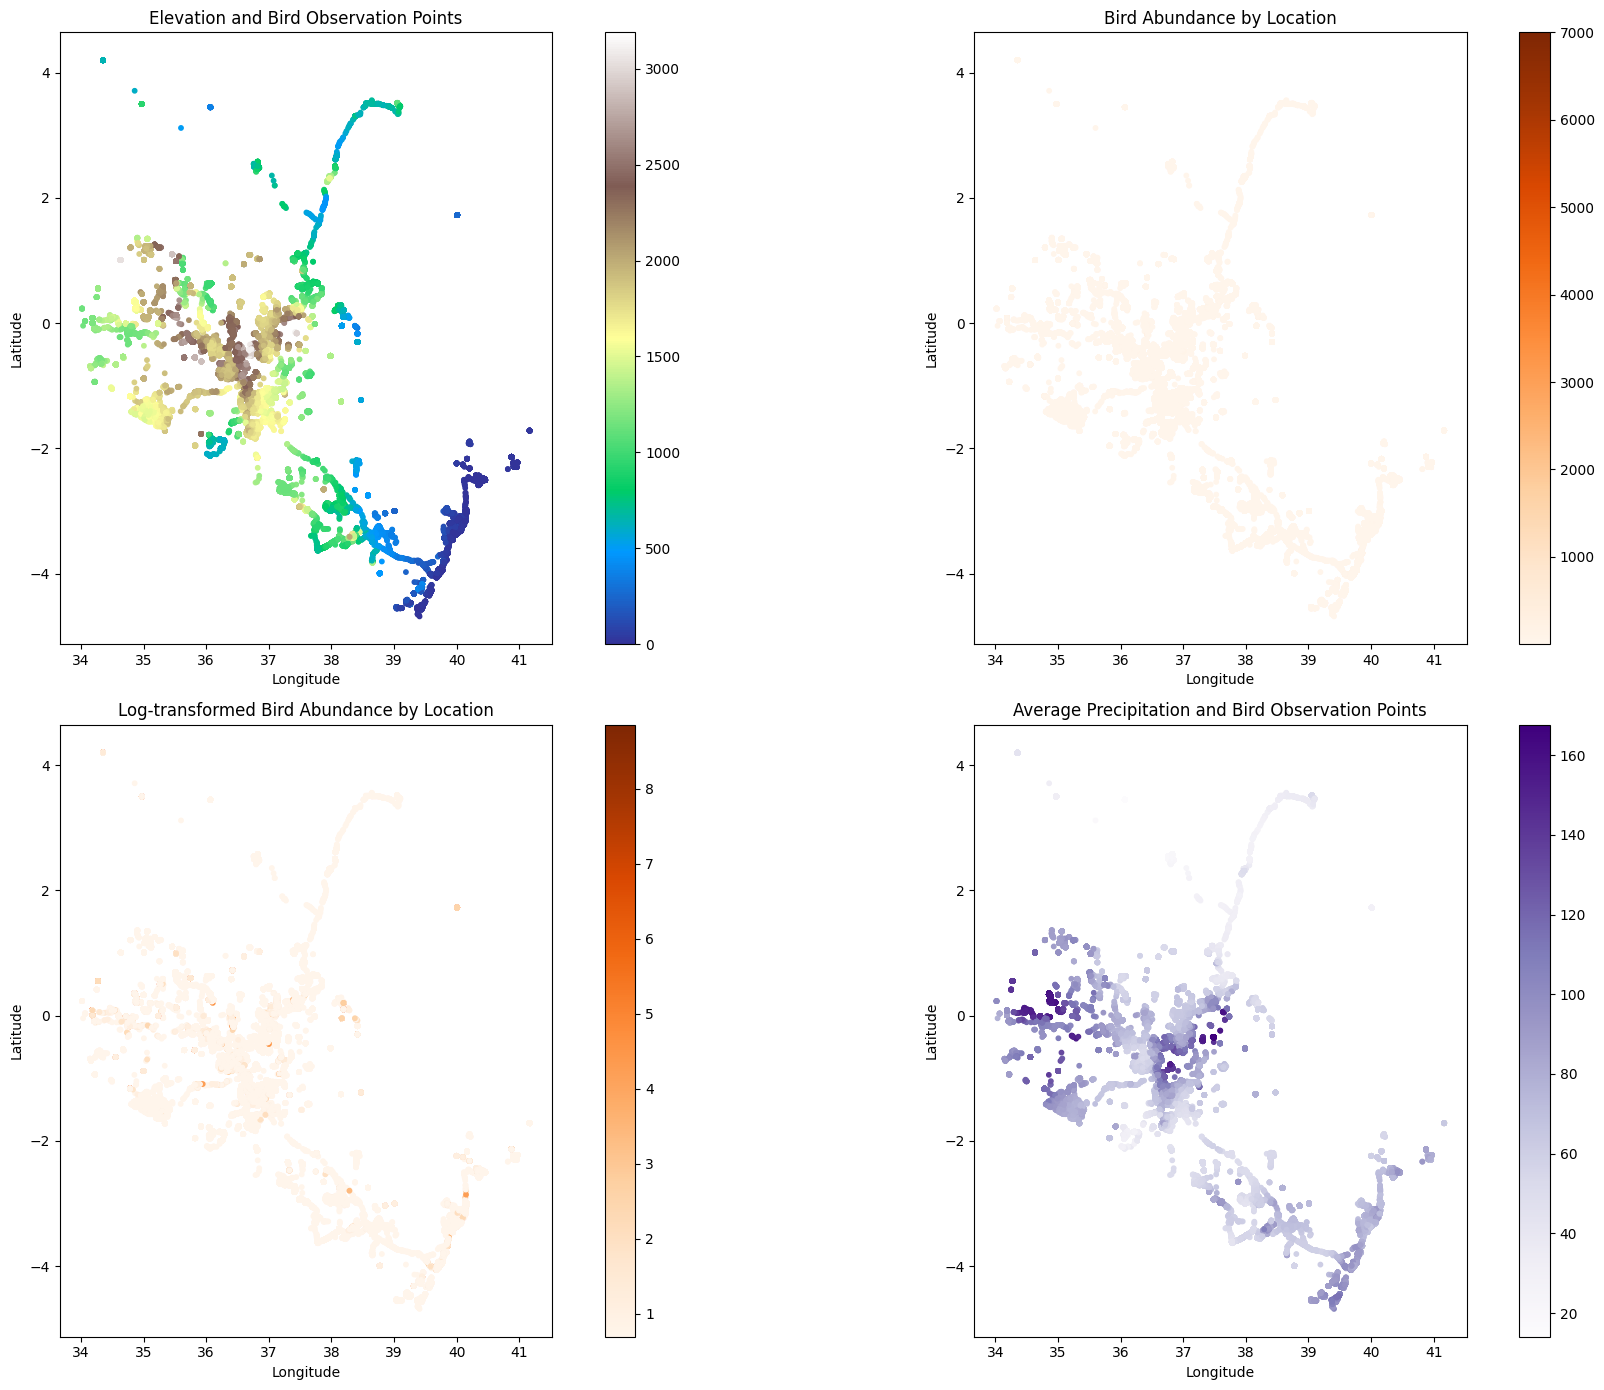

In [40]:
# Map bird abundance with elevation, average precipitation
fig, ax = plt.subplots(2, 2, figsize=(20, 14))

# Flatten the array for easier indexing
ax = ax.flatten()

# Map elevation
occurrence_gdf.plot(column='elevation', cmap='terrain', ax=ax[0], legend=True, markersize=10)
ax[0].set_title("Elevation and Bird Observation Points")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

# Map bird abundance
occurrence_gdf.plot(column='individualCount', cmap='Oranges', ax=ax[1], legend=True, markersize=10)
ax[1].set_title("Bird Abundance by Location")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

# Map log-transformed bird abundance
occurrence_gdf.plot(column='log_individualCount', cmap='Oranges', ax=ax[2], legend=True, markersize=10)
ax[2].set_title("Log-transformed Bird Abundance by Location")
ax[2].set_xlabel("Longitude")
ax[2].set_ylabel("Latitude")

# Map average precipitation
occurrence_gdf.plot(column='average_precipitation', cmap='Purples', ax=ax[3], legend=True, markersize=10)
ax[3].set_title("Average Precipitation and Bird Observation Points")
ax[3].set_xlabel("Longitude")
ax[3].set_ylabel("Latitude")

plt.tight_layout()
plt.show()

Applying quantile-based binning for elevation and precipitation...


/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_44480/2162132221.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elevation_bins = occurrence_gdf.groupby('elevation_bin')['individualCount'].mean()
/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_44480/2162132221.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precipitation_bins = occurrence_gdf.groupby('precipitation_bin')['individualCount'].mean()


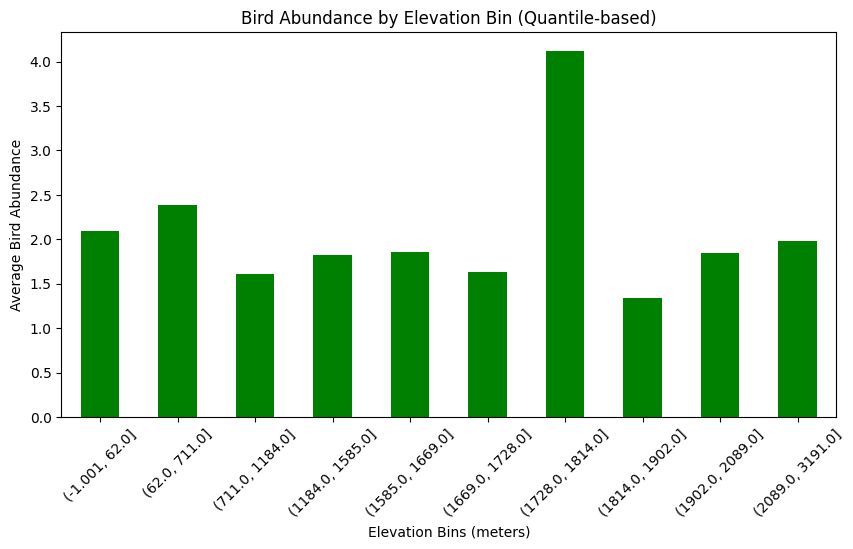

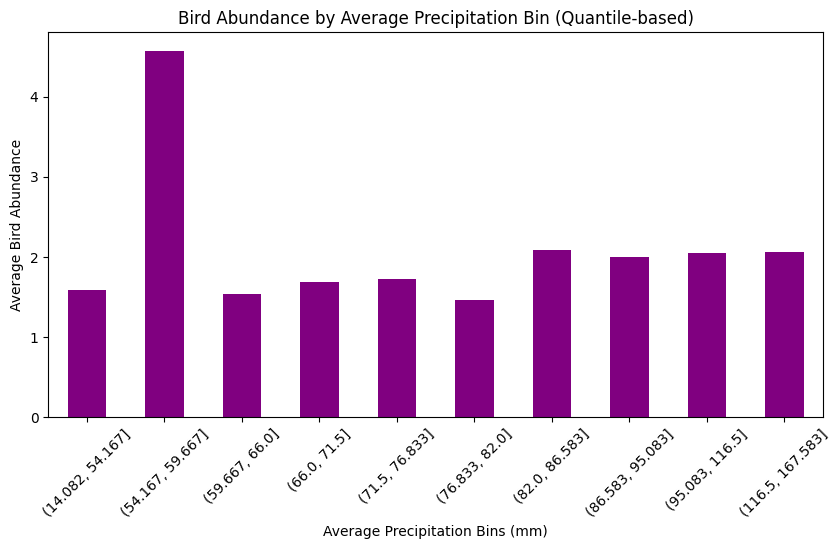

In [41]:
# Quantile-based binning for elevation and precipitation
print("Applying quantile-based binning for elevation and precipitation...")
occurrence_gdf['elevation_bin'] = pd.qcut(occurrence_gdf['elevation'], q=10)  # 10 quantile-based bins
occurrence_gdf['precipitation_bin'] = pd.qcut(occurrence_gdf['average_precipitation'], q=10)  # 10 quantile-based bins

# Group by bins and calculate average bird abundance
elevation_bins = occurrence_gdf.groupby('elevation_bin')['individualCount'].mean()
precipitation_bins = occurrence_gdf.groupby('precipitation_bin')['individualCount'].mean()

# Plot bird abundance by elevation bin
plt.figure(figsize=(10, 5))
elevation_bins.plot(kind='bar', color='green')
plt.title("Bird Abundance by Elevation Bin (Quantile-based)")
plt.xlabel("Elevation Bins (meters)")
plt.ylabel("Average Bird Abundance")
plt.xticks(rotation=45)
plt.show()

# Plot bird abundance by precipitation bin
plt.figure(figsize=(10, 5))
precipitation_bins.plot(kind='bar', color='purple')
plt.title("Bird Abundance by Average Precipitation Bin (Quantile-based)")
plt.xlabel("Average Precipitation Bins (mm)")
plt.ylabel("Average Bird Abundance")
plt.xticks(rotation=45)
plt.show()

In [42]:
columns_to_normalize = ['elevation', 'individualCount', 'log_individualCount', 'average_precipitation']
occurrence_gdf[columns_to_normalize] = occurrence_gdf[columns_to_normalize].apply(zscore)

In [43]:
# Function to calculate and print correlations between each pair of variables
def calculate_correlations(df, cols):
    correlation_results = {}
    for i, col1 in enumerate(cols):
        for col2 in cols[i+1:]:
            pearson_corr, _ = pearsonr(df[col1], df[col2])
            spearman_corr, _ = spearmanr(df[col1], df[col2])
            kendall_corr, _ = kendalltau(df[col1], df[col2])
            correlation_results[(col1, col2)] = {
                'Pearson': pearson_corr,
                'Spearman': spearman_corr,
                'Kendall Tau': kendall_corr
            }
    return correlation_results

cols_to_check = ['elevation', 'individualCount', 'log_individualCount', 'average_precipitation']
correlation_results = calculate_correlations(occurrence_gdf, cols_to_check)

for (col1, col2), values in correlation_results.items():
    print(f"\nCorrelation between {col1} and {col2}:")
    print(f"  Pearson Correlation: {values['Pearson']:.2f}")
    print(f"  Spearman Correlation: {values['Spearman']:.2f}")
    print(f"  Kendall Tau Correlation: {values['Kendall Tau']:.2f}")


Correlation between elevation and individualCount:
  Pearson Correlation: -0.00
  Spearman Correlation: -0.06
  Kendall Tau Correlation: -0.05

Correlation between elevation and log_individualCount:
  Pearson Correlation: -0.05
  Spearman Correlation: -0.06
  Kendall Tau Correlation: -0.05

Correlation between elevation and average_precipitation:
  Pearson Correlation: 0.21
  Spearman Correlation: 0.18
  Kendall Tau Correlation: 0.12

Correlation between individualCount and log_individualCount:
  Pearson Correlation: 0.24
  Spearman Correlation: 1.00
  Kendall Tau Correlation: 1.00

Correlation between individualCount and average_precipitation:
  Pearson Correlation: -0.00
  Spearman Correlation: 0.11
  Kendall Tau Correlation: 0.08

Correlation between log_individualCount and average_precipitation:
  Pearson Correlation: 0.06
  Spearman Correlation: 0.11
  Kendall Tau Correlation: 0.08


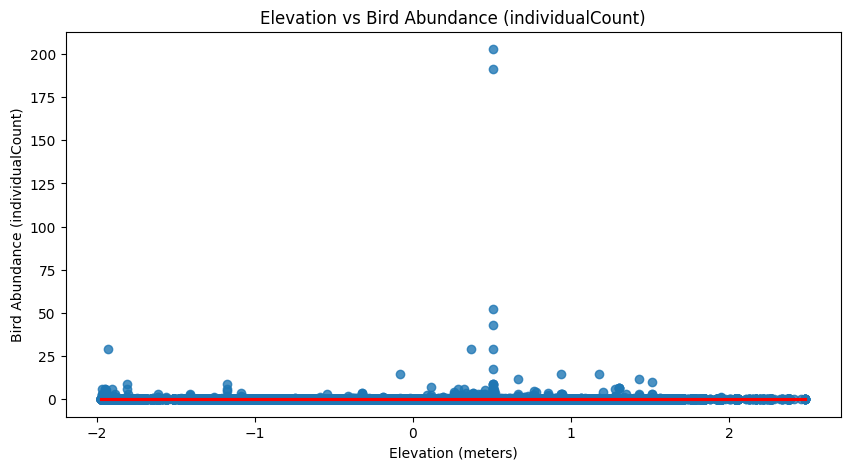

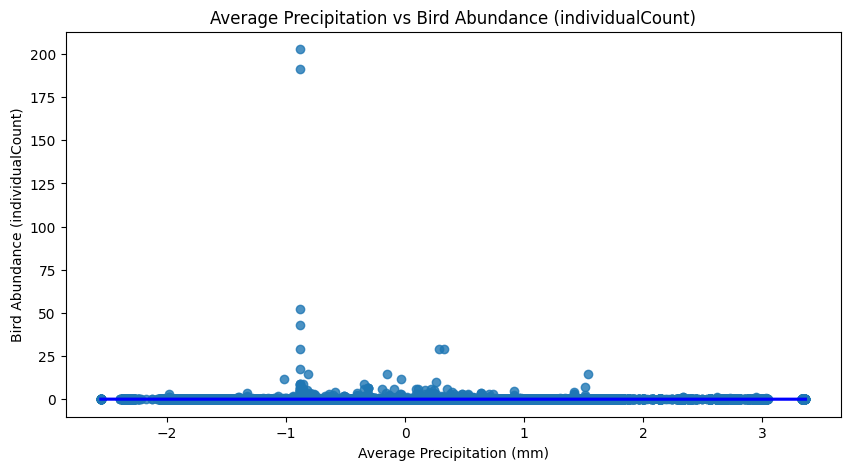

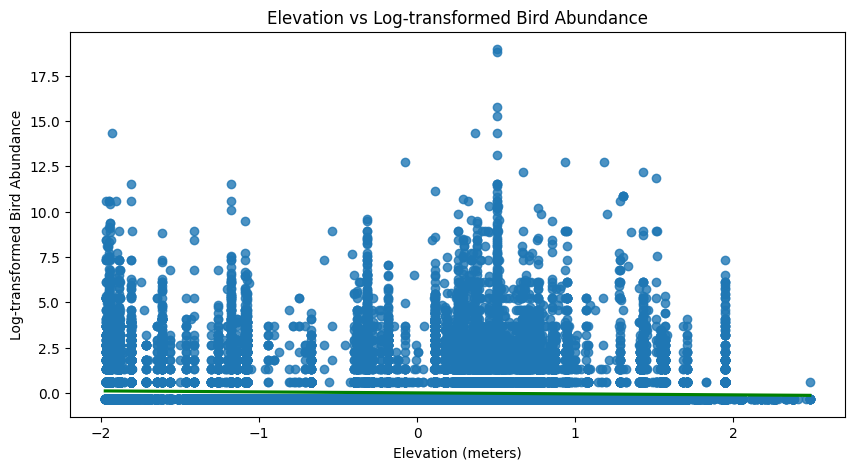

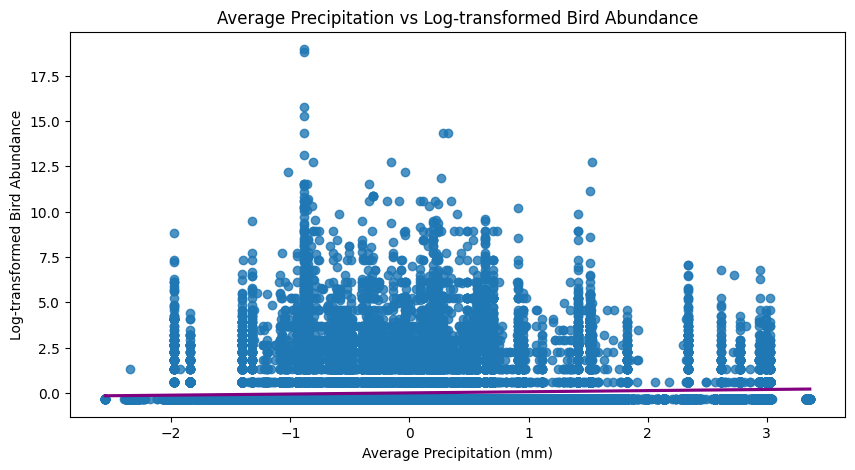

In [44]:
# Scatter plot for Elevation vs Bird Abundance (individualCount) with trendline
plt.figure(figsize=(10, 5))
sns.regplot(x=occurrence_gdf['elevation'], y=occurrence_gdf['individualCount'], line_kws={"color": "red"})
plt.title("Elevation vs Bird Abundance (individualCount)")
plt.xlabel("Elevation (meters)")
plt.ylabel("Bird Abundance (individualCount)")
plt.show()

# Scatter plot for Average Precipitation vs Bird Abundance (individualCount) with trendline
plt.figure(figsize=(10, 5))
sns.regplot(x=occurrence_gdf['average_precipitation'], y=occurrence_gdf['individualCount'], line_kws={"color": "blue"})
plt.title("Average Precipitation vs Bird Abundance (individualCount)")
plt.xlabel("Average Precipitation (mm)")
plt.ylabel("Bird Abundance (individualCount)")
plt.show()

# Scatter plot for Elevation vs Log-transformed Bird Abundance with trendline
plt.figure(figsize=(10, 5))
sns.regplot(x=occurrence_gdf['elevation'], y=occurrence_gdf['log_individualCount'], line_kws={"color": "green"})
plt.title("Elevation vs Log-transformed Bird Abundance")
plt.xlabel("Elevation (meters)")
plt.ylabel("Log-transformed Bird Abundance")
plt.show()

# Scatter plot for Average Precipitation vs Log-transformed Bird Abundance with trendline
plt.figure(figsize=(10, 5))
sns.regplot(x=occurrence_gdf['average_precipitation'], y=occurrence_gdf['log_individualCount'], line_kws={"color": "purple"})
plt.title("Average Precipitation vs Log-transformed Bird Abundance")
plt.xlabel("Average Precipitation (mm)")
plt.ylabel("Log-transformed Bird Abundance")
plt.show()


In [45]:
import scipy.stats as stats

# ANOVA test for elevation bins
occurrence_gdf['elevation_bin'] = pd.qcut(occurrence_gdf['elevation'], q=4)  # Quartile-based bins for elevation
elevation_groups = [group['log_individualCount'].values for _, group in occurrence_gdf.groupby('elevation_bin')]
f_stat_elev, p_value_elev = stats.f_oneway(*elevation_groups)
print(f"ANOVA for Elevation Bins: F-statistic = {f_stat_elev:.4f}, p-value = {p_value_elev:.4f}")

# ANOVA test for precipitation bins
occurrence_gdf['precipitation_bin'] = pd.qcut(occurrence_gdf['average_precipitation'], q=4)  # Quartile-based bins for precipitation
precipitation_groups = [group['log_individualCount'].values for _, group in occurrence_gdf.groupby('precipitation_bin')]
f_stat_precip, p_value_precip = stats.f_oneway(*precipitation_groups)
print(f"ANOVA for Precipitation Bins: F-statistic = {f_stat_precip:.4f}, p-value = {p_value_precip:.4f}")


/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_44480/3465040093.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elevation_groups = [group['log_individualCount'].values for _, group in occurrence_gdf.groupby('elevation_bin')]
/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_44480/3465040093.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precipitation_groups = [group['log_individualCount'].values for _, group in occurrence_gdf.groupby('precipitation_bin')]


ANOVA for Elevation Bins: F-statistic = 193.9475, p-value = 0.0000
ANOVA for Precipitation Bins: F-statistic = 229.9481, p-value = 0.0000


### Question 4

In [46]:
df = pd.read_csv('./data/GBIT_annotated_archive/DARWIN_CORE_ARCHIVE/0020723-241024112534372/occurrence.txt', delimiter='\t')
df_kenya = df[(df['countryCode'] == 'KE') & df['decimalLatitude'].notna() & df['decimalLongitude'].notna()]

gdf = gpd.GeoDataFrame(
    df_kenya,
    geometry=gpd.points_from_xy(df_kenya['decimalLongitude'], df_kenya['decimalLatitude']),
    crs='EPSG:4326'
)

# Group by location and count unique species
species_richness = gdf.groupby(['decimalLatitude', 'decimalLongitude']).agg({'scientificName': 'nunique'}).reset_index()
species_richness.rename(columns={'scientificName': 'species_count'}, inplace=True)

gdf_richness = gpd.GeoDataFrame(
    species_richness,
    geometry=gpd.points_from_xy(species_richness['decimalLongitude'], species_richness['decimalLatitude']),
    crs='EPSG:4326'
)

/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_44480/4075956425.py:1: DtypeWarning: Columns (170) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/GBIT_annotated_archive/DARWIN_CORE_ARCHIVE/0020723-241024112534372/occurrence.txt', delimiter='\t')


/usr/local/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


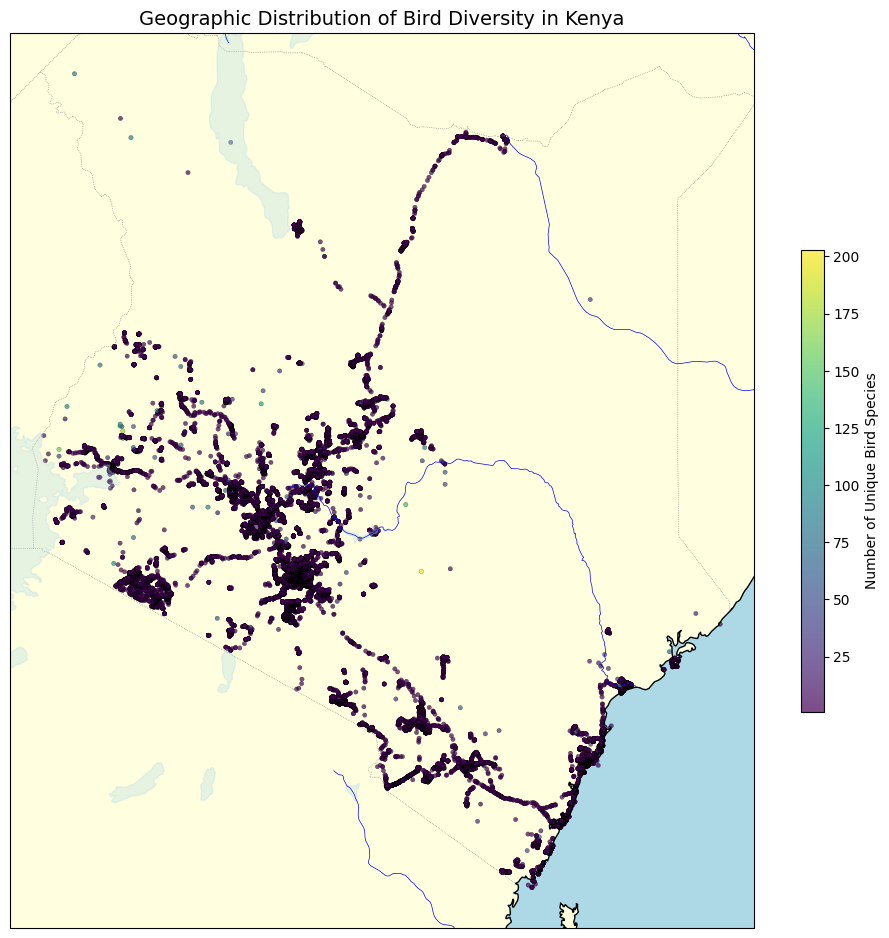

In [47]:
# Plot the geographic distribution of bird diversity in Kenya
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Add more geographic features using cartopy's cfeature library
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=0.5)  # National borders
ax.add_feature(cfeature.COASTLINE, edgecolor='black')  # Coastline
ax.add_feature(cfeature.LAKES, alpha=0.3, color='lightblue')  # Lakes
ax.add_feature(cfeature.RIVERS, linewidth=0.5, color='blue')  # Rivers
ax.add_feature(cfeature.LAND, facecolor='lightyellow')  # Land color
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Ocean color

# Plot species richness data as points with color intensity based on richness
scatter = ax.scatter(
    gdf_richness['decimalLongitude'],
    gdf_richness['decimalLatitude'],
    c=gdf_richness['species_count'],
    cmap='viridis',
    s=10,
    transform=ccrs.PlateCarree(),
    alpha=0.7,
    edgecolor='black',  # Adding a thin border around points for visibility
    linewidth=0.2
)

# Add a colorbar to indicate species richness levels
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('Number of Unique Bird Species')

ax.set_title('Geographic Distribution of Bird Diversity in Kenya', fontsize=14)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.show()

/usr/local/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


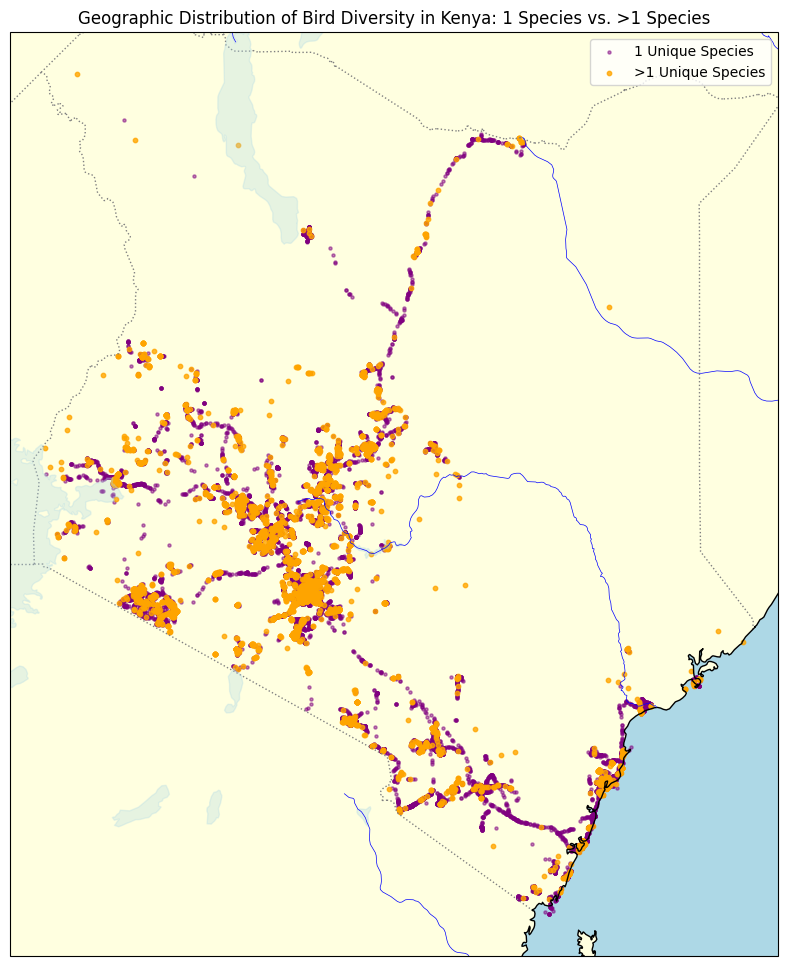

In [48]:
# Separate locations with species richness of 1 and more than 1
single_species = gdf_richness[gdf_richness['species_count'] == 1]
multiple_species = gdf_richness[gdf_richness['species_count'] > 1]

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.LAKES, alpha=0.3, color='lightblue')
ax.add_feature(cfeature.RIVERS, linewidth=0.5, color='blue')
ax.add_feature(cfeature.LAND, facecolor='lightyellow')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot locations with only 1 species in one color (e.g., dark purple)
scatter1 = ax.scatter(
    single_species['decimalLongitude'],
    single_species['decimalLatitude'],
    color='purple',
    s=5,  # Make these points smaller due to high number
    transform=ccrs.PlateCarree(),
    alpha=0.5,
    label='1 Unique Species'
)

# Plot locations with more than 1 species in another color (e.g., orange)
scatter2 = ax.scatter(
    multiple_species['decimalLongitude'],
    multiple_species['decimalLatitude'],
    color='orange',
    s=10,  # Larger points to highlight high-diversity locations
    transform=ccrs.PlateCarree(),
    alpha=0.8,
    label='>1 Unique Species'
)

ax.legend(loc='upper right', fontsize=10)
ax.set_title('Geographic Distribution of Bird Diversity in Kenya: 1 Species vs. >1 Species')
plt.show()

do grid based approach:

/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_44480/701073287.py:1: DtypeWarning: Columns (170) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/GBIT_annotated_archive/DARWIN_CORE_ARCHIVE/0020723-241024112534372/occurrence.txt', delimiter='\t')
/usr/local/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


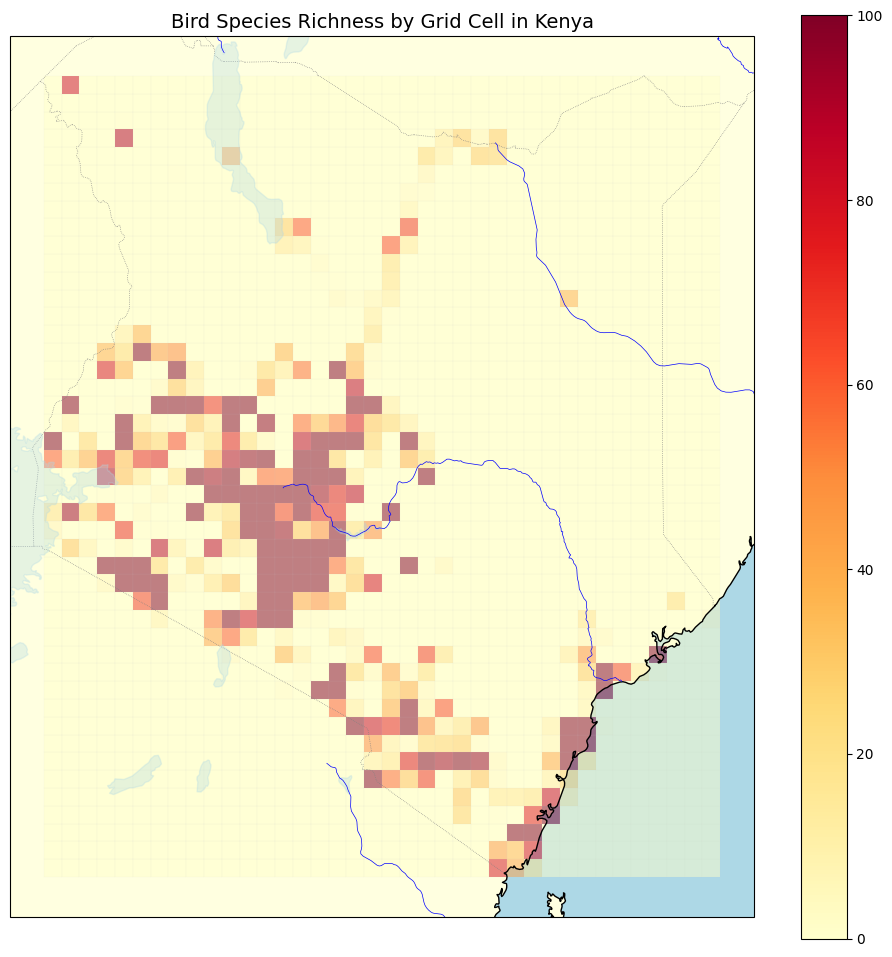

In [54]:
df = pd.read_csv('./data/GBIT_annotated_archive/DARWIN_CORE_ARCHIVE/0020723-241024112534372/occurrence.txt', delimiter='\t')
df_kenya = df[(df['countryCode'] == 'KE') & df['decimalLatitude'].notna() & df['decimalLongitude'].notna()]

# Convert bird data to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_kenya,
    geometry=gpd.points_from_xy(df_kenya['decimalLongitude'], df_kenya['decimalLatitude']),
    crs='EPSG:4326'
)

# Define grid parameters (adjust grid size as needed)
minx, miny, maxx, maxy = gdf.total_bounds  # Bounding box of Kenya's bird observations
cell_size = 0.2  # Grid cell size in degrees

minx, miny, maxx, maxy = gdf.total_bounds  # Bounding box of Kenya's bird observations
cell_size = 0.2  # Grid cell size in degrees

# Create a grid of polygons (cells) across Kenya
grid_cells = []
for x in np.arange(minx, maxx, cell_size):
    for y in np.arange(miny, maxy, cell_size):
        grid_cells.append(box(x, y, x + cell_size, y + cell_size))

grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='EPSG:4326')

# Spatial join each observation to its corresponding grid cell
joined = gpd.sjoin(gdf, grid, how="left", predicate="within")

# Calculate species richness by counting unique species per grid cell
species_richness = joined.groupby("index_right").agg({"scientificName": "nunique"}).reset_index()
species_richness.columns = ["grid_id", "species_count"]

# Merge species richness back to grid cells GeoDataFrame
grid = grid.reset_index().rename(columns={"index": "grid_id"})
grid = grid.merge(species_richness, on="grid_id", how="left")
grid["species_count"] = grid["species_count"].fillna(0)

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.LAKES, alpha=0.3, color='lightblue')
ax.add_feature(cfeature.RIVERS, linewidth=0.5, color='blue')
ax.add_feature(cfeature.LAND, facecolor='lightyellow')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

grid.plot(
    column='species_count', 
    cmap='YlOrRd',  # Softer colormap transitioning from yellow to red
    linewidth=0.1,  # Lighten grid borders
    edgecolor='lightgray', 
    ax=ax, 
    legend=True,
    alpha=0.5,  # Increase transparency for a lighter appearance
    vmin=0, vmax=grid['species_count'].quantile(0.95)  # Adjust color range to avoid dark cells
)

ax.set_title('Bird Species Richness by Grid Cell in Kenya', fontsize=14)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.show()